In [1]:
!rm -rf img/ && mkdir -p img

In [2]:
import figtools as ftl
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.optim

from helper import UKF
from helper import generate_data

In [3]:
torch.manual_seed(0)
assert torch.all(torch.randint(10, (10,)) == torch.tensor([4, 9, 3, 0, 3, 9, 7, 3, 7, 3]))

In [4]:
X, X_gt = generate_data(phi=torch.tensor([0., np.pi / 2., np.pi, 3. / 2. * np.pi]),
                        v0=torch.tensor([1., 2., 3., 4.]),
                        noise=torch.tensor([[.5, .5], [.5, .5], [.5, .5], [.5, .5]]),
                        n=30,
                        n_repeat=100)

X.shape

torch.Size([4, 2, 3000])

In [5]:
def train_step(X, *, phi_noise, learning_rate):
    b, _, n = X.shape

    optimizer = torch.optim.SGD([phi_noise,], lr=learning_rate)

    while True:
        optimizer.zero_grad()

        ukf = UKF(phi_noise=phi_noise)
        loss = torch.zeros((b,))

        for i in range(n):
            _, error = ukf.step(X[:, :, i])
            loss += error

        loss.backward(torch.ones(b))
        optimizer.step()

        yield loss.tolist()


def train(*, n_iter, batch_size):
    phi_noise = torch.tensor([np.pi / 6., np.pi / 6., np.pi / 6., np.pi / 6.], requires_grad=True)
    begin = 0

    loss = []
    for i in range(n_iter):
        _, _, n = X.shape
        if begin + batch_size > n:
            begin = 0
        end = begin + batch_size
        print(f'{i} / {n_iter}: {begin} .. {end}')

        gen = train_step(X[:, :, begin:begin + batch_size], phi_noise=phi_noise, learning_rate=.001)
        for _ in range(10):
            loss.append((next(gen), phi_noise.tolist()))

        begin += batch_size

    return np.array(loss).T


loss = train(n_iter=25, batch_size=120)
loss.shape

0 / 25: 0 .. 120
1 / 25: 120 .. 240
2 / 25: 240 .. 360
3 / 25: 360 .. 480
4 / 25: 480 .. 600
5 / 25: 600 .. 720
6 / 25: 720 .. 840
7 / 25: 840 .. 960
8 / 25: 960 .. 1080
9 / 25: 1080 .. 1200
10 / 25: 1200 .. 1320
11 / 25: 1320 .. 1440
12 / 25: 1440 .. 1560
13 / 25: 1560 .. 1680
14 / 25: 1680 .. 1800
15 / 25: 1800 .. 1920
16 / 25: 1920 .. 2040
17 / 25: 2040 .. 2160
18 / 25: 2160 .. 2280
19 / 25: 2280 .. 2400
20 / 25: 2400 .. 2520
21 / 25: 2520 .. 2640
22 / 25: 2640 .. 2760
23 / 25: 2760 .. 2880
24 / 25: 2880 .. 3000


(4, 2, 250)

[Download loss_vs_dphi0.png],[Download loss_vs_dphi1.png]
[Download loss_vs_dphi2.png],[Download loss_vs_dphi3.png]

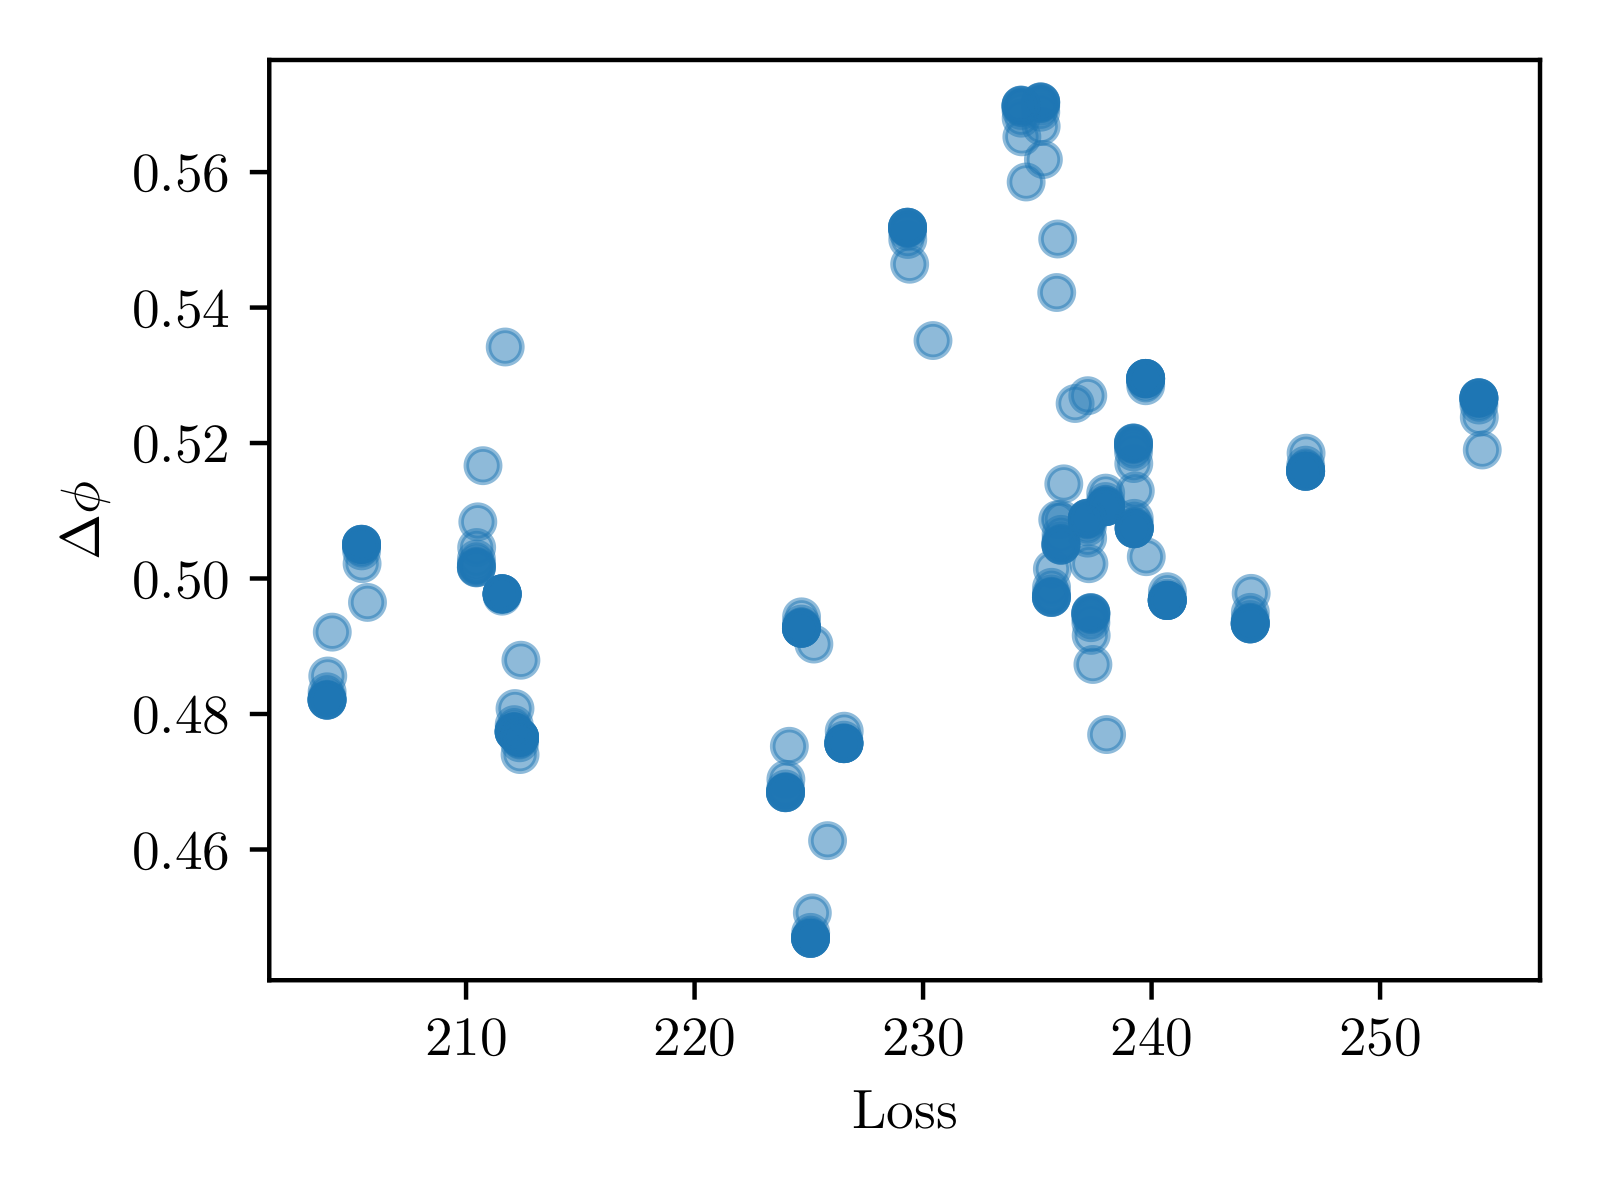
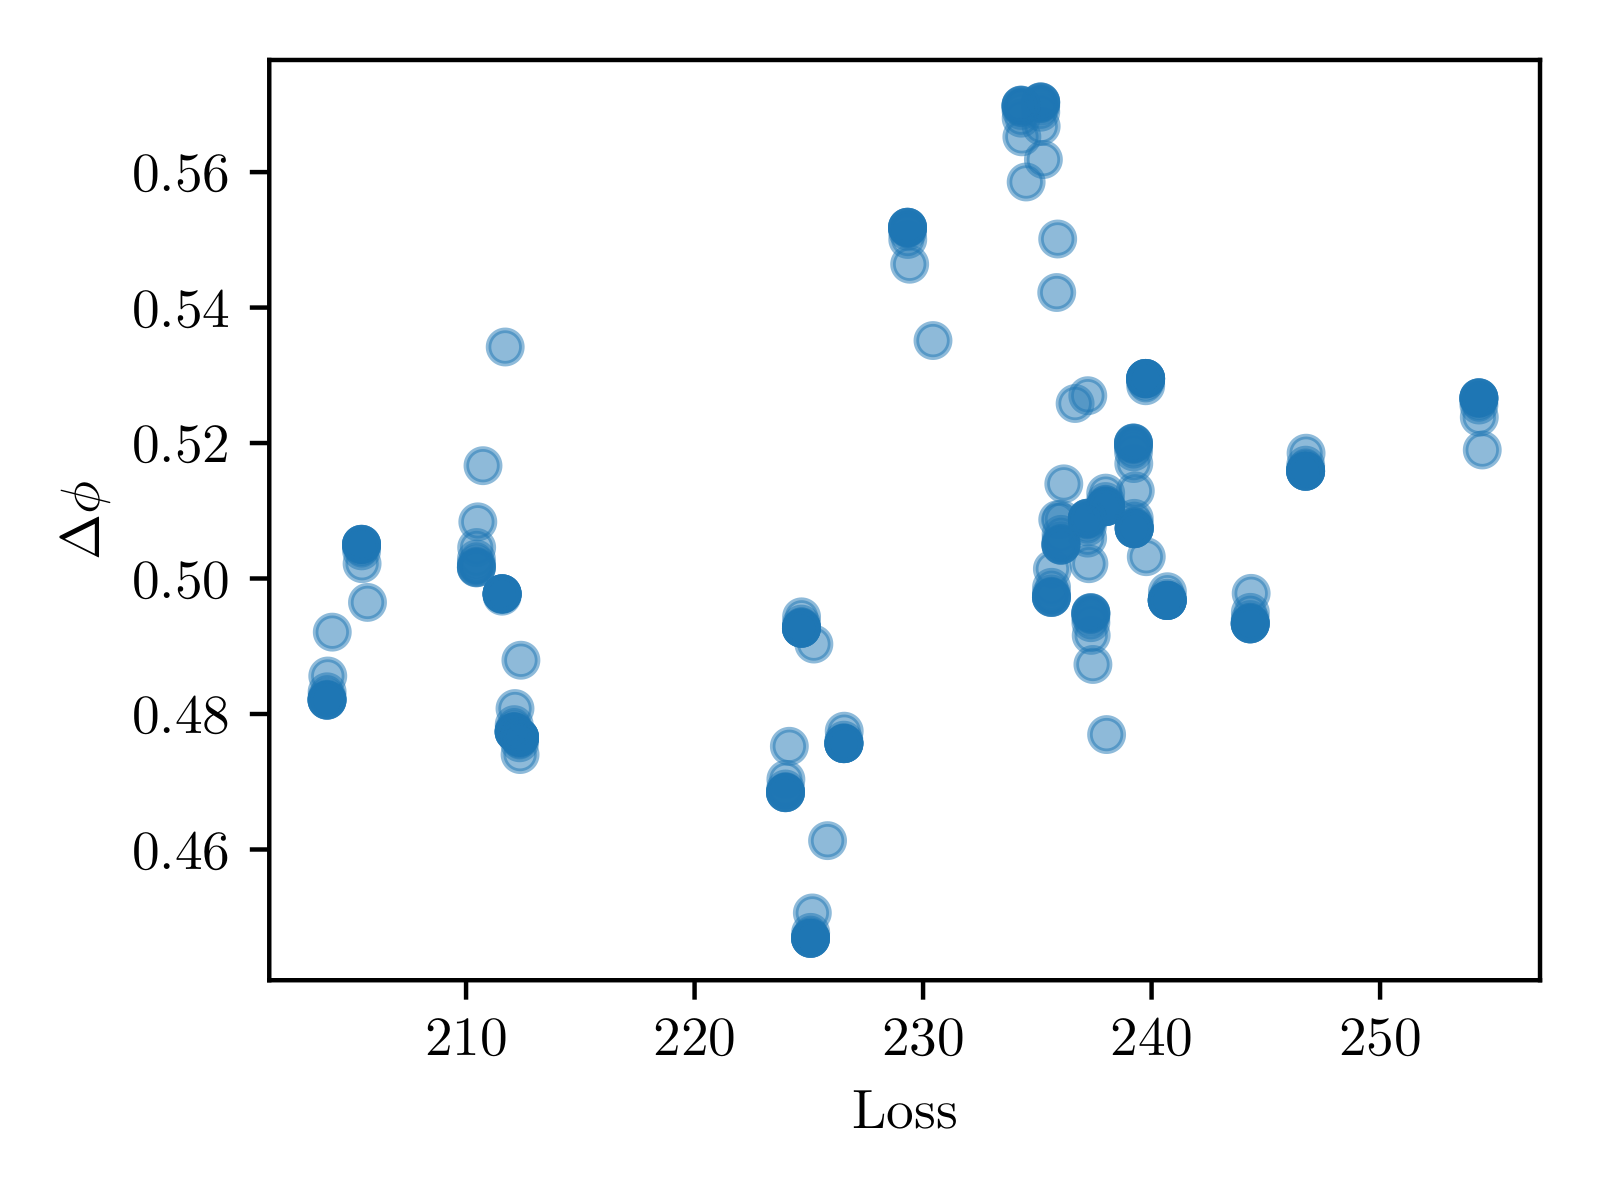
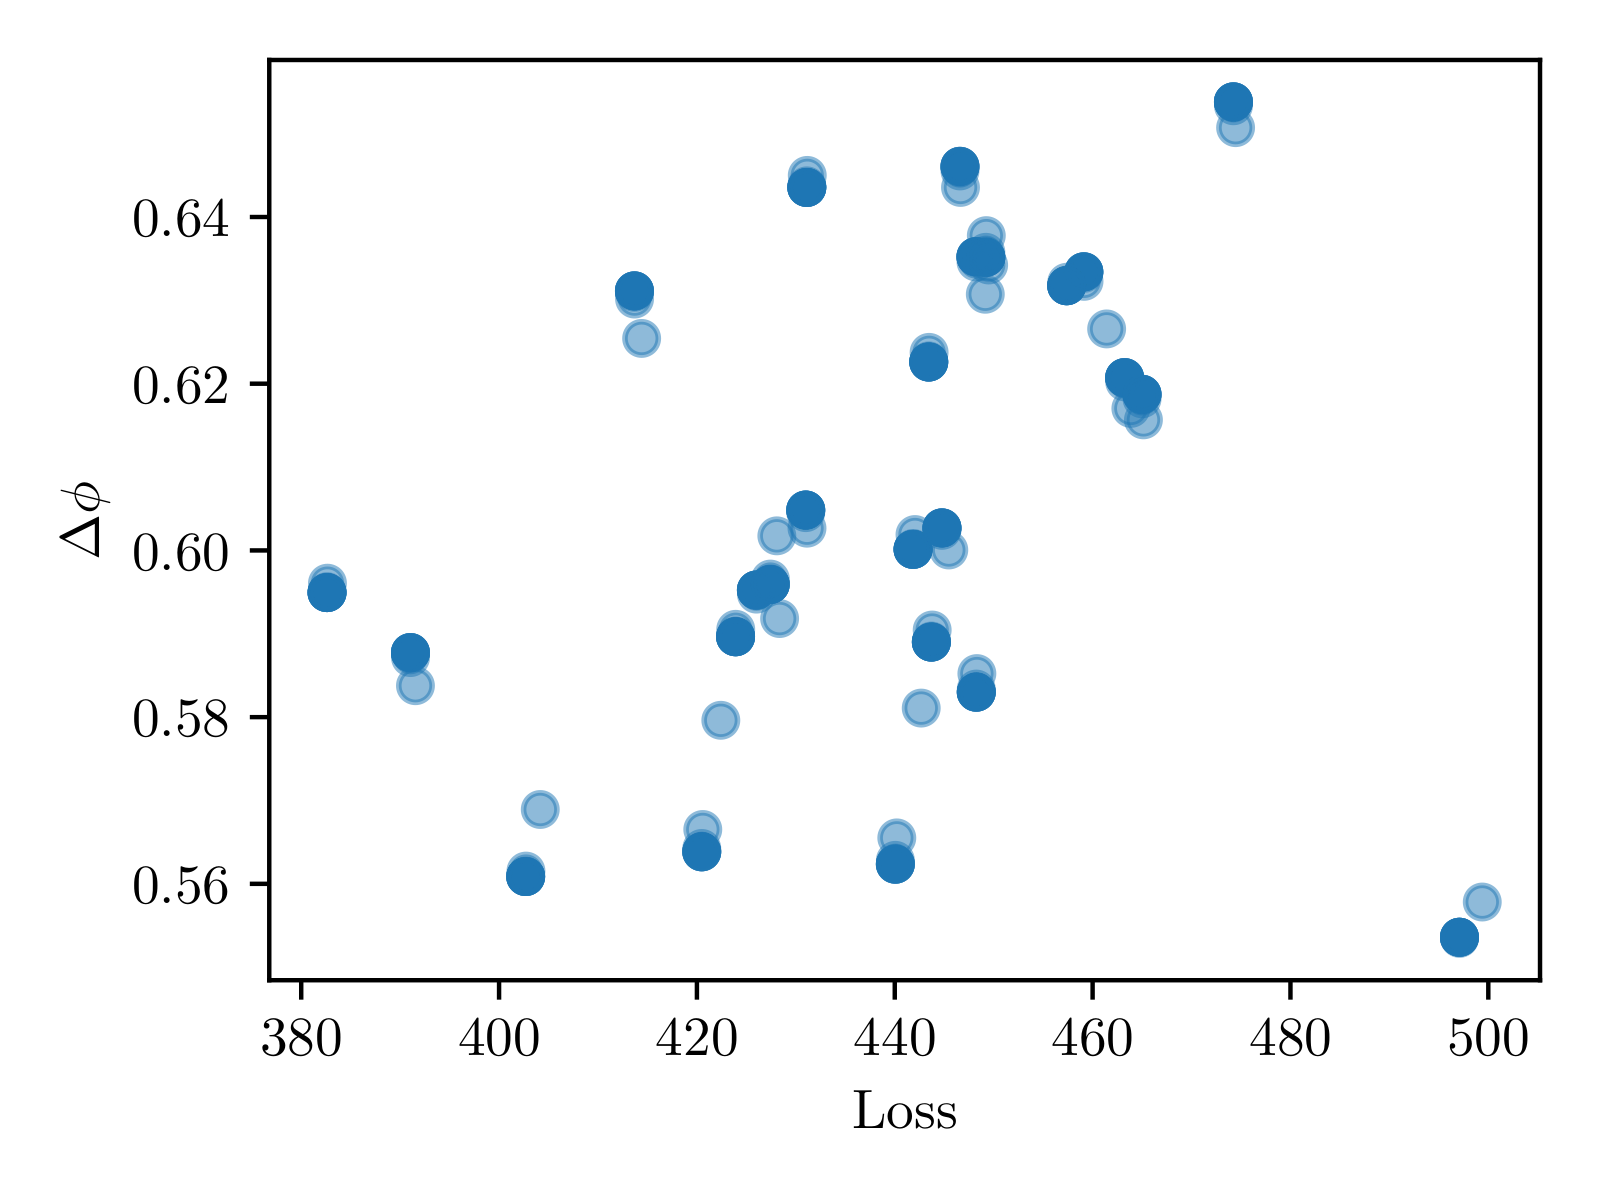
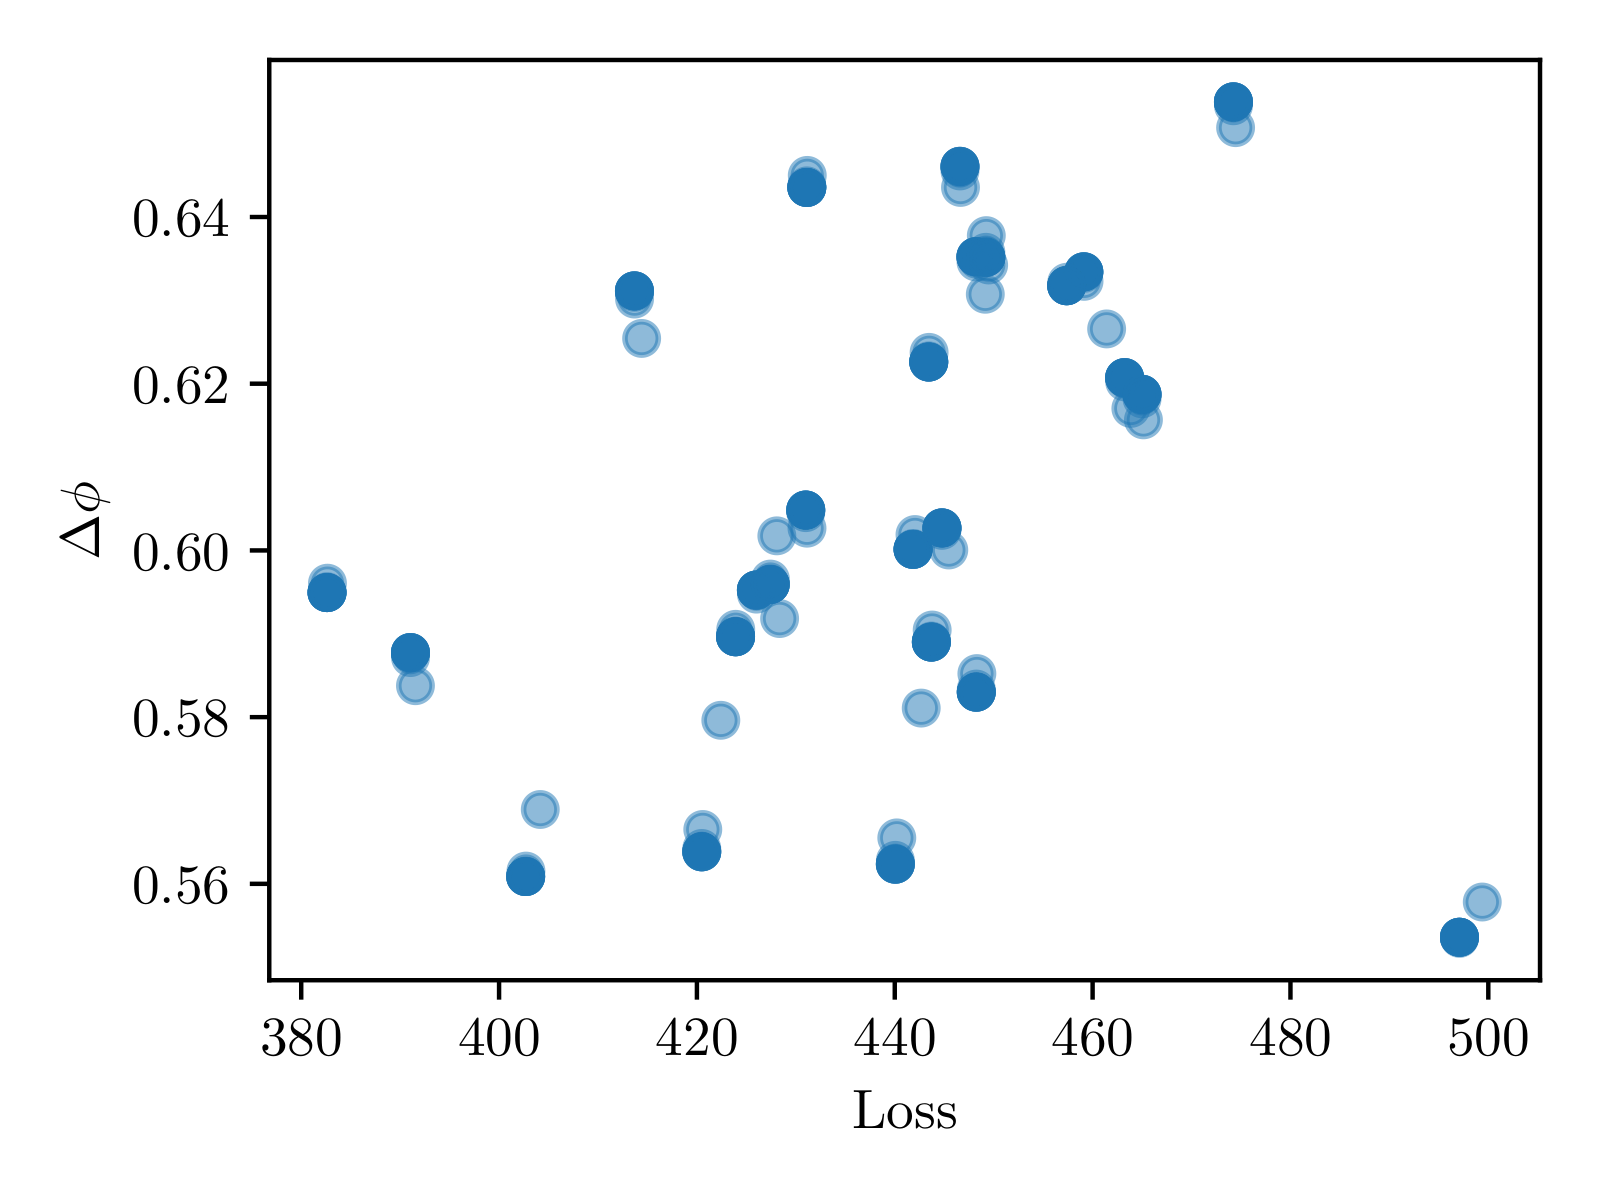
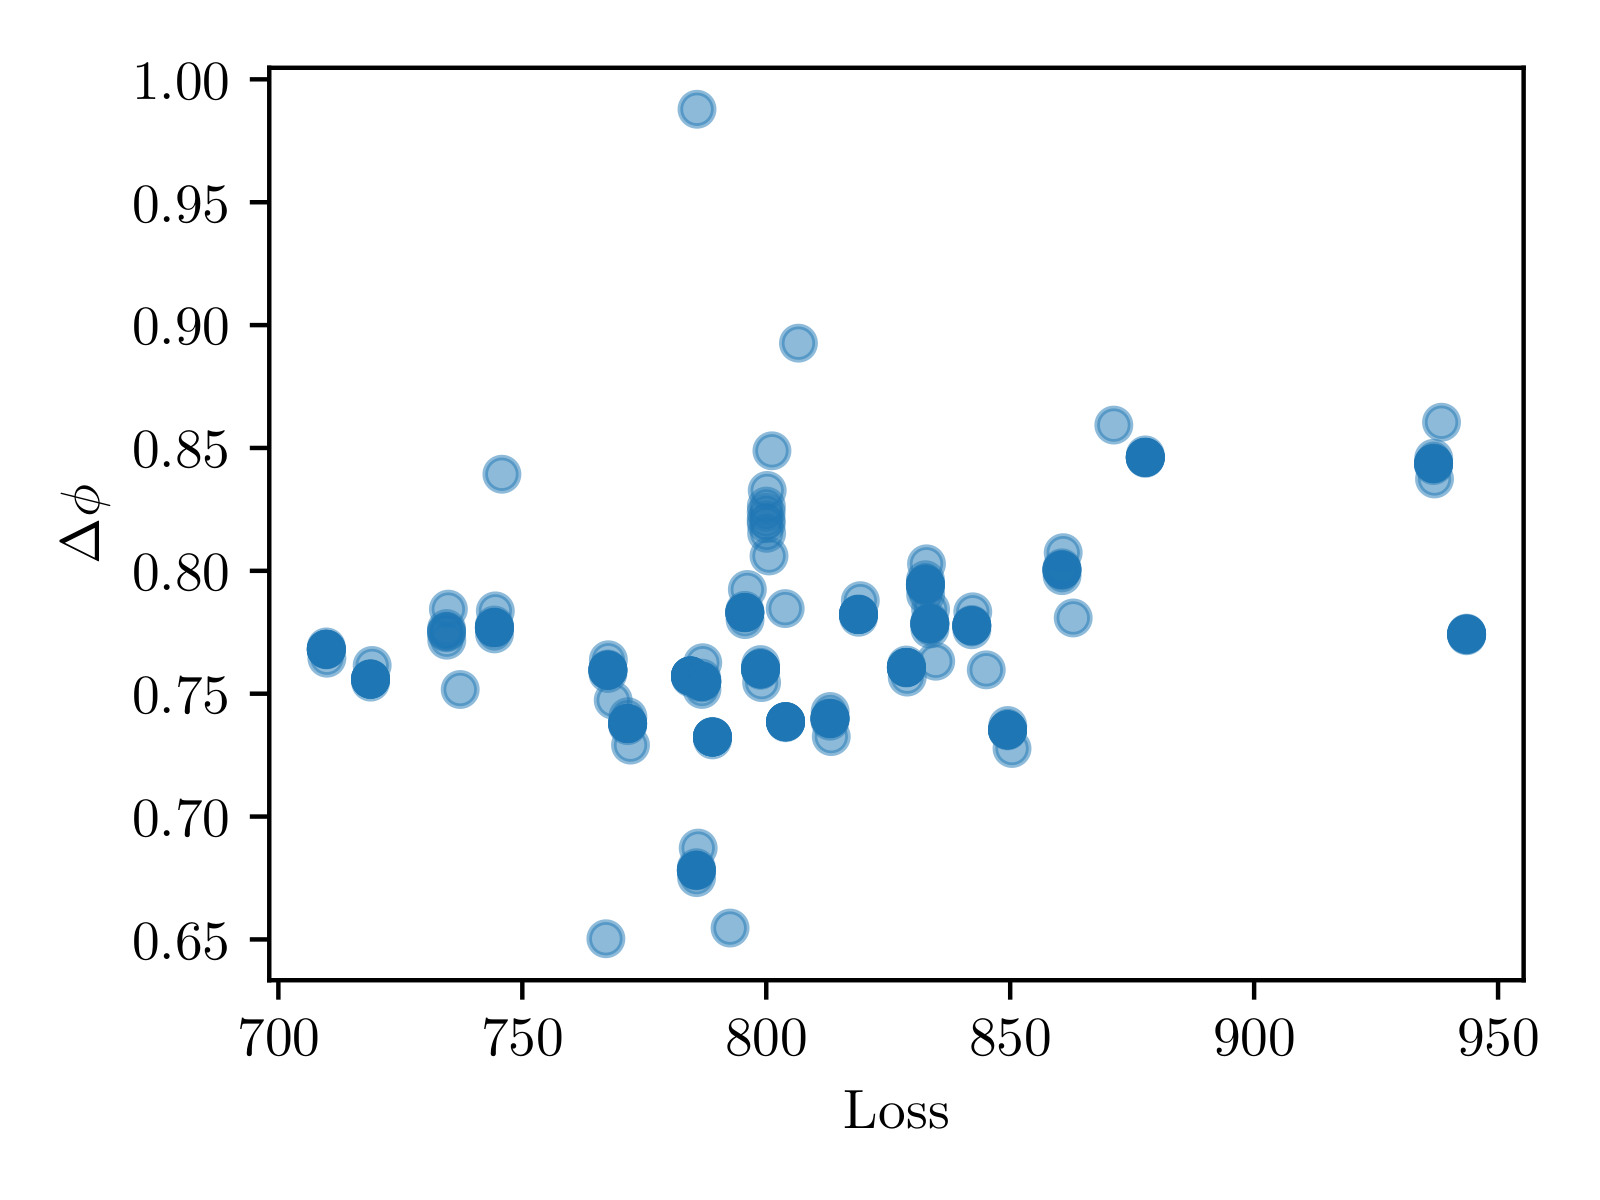
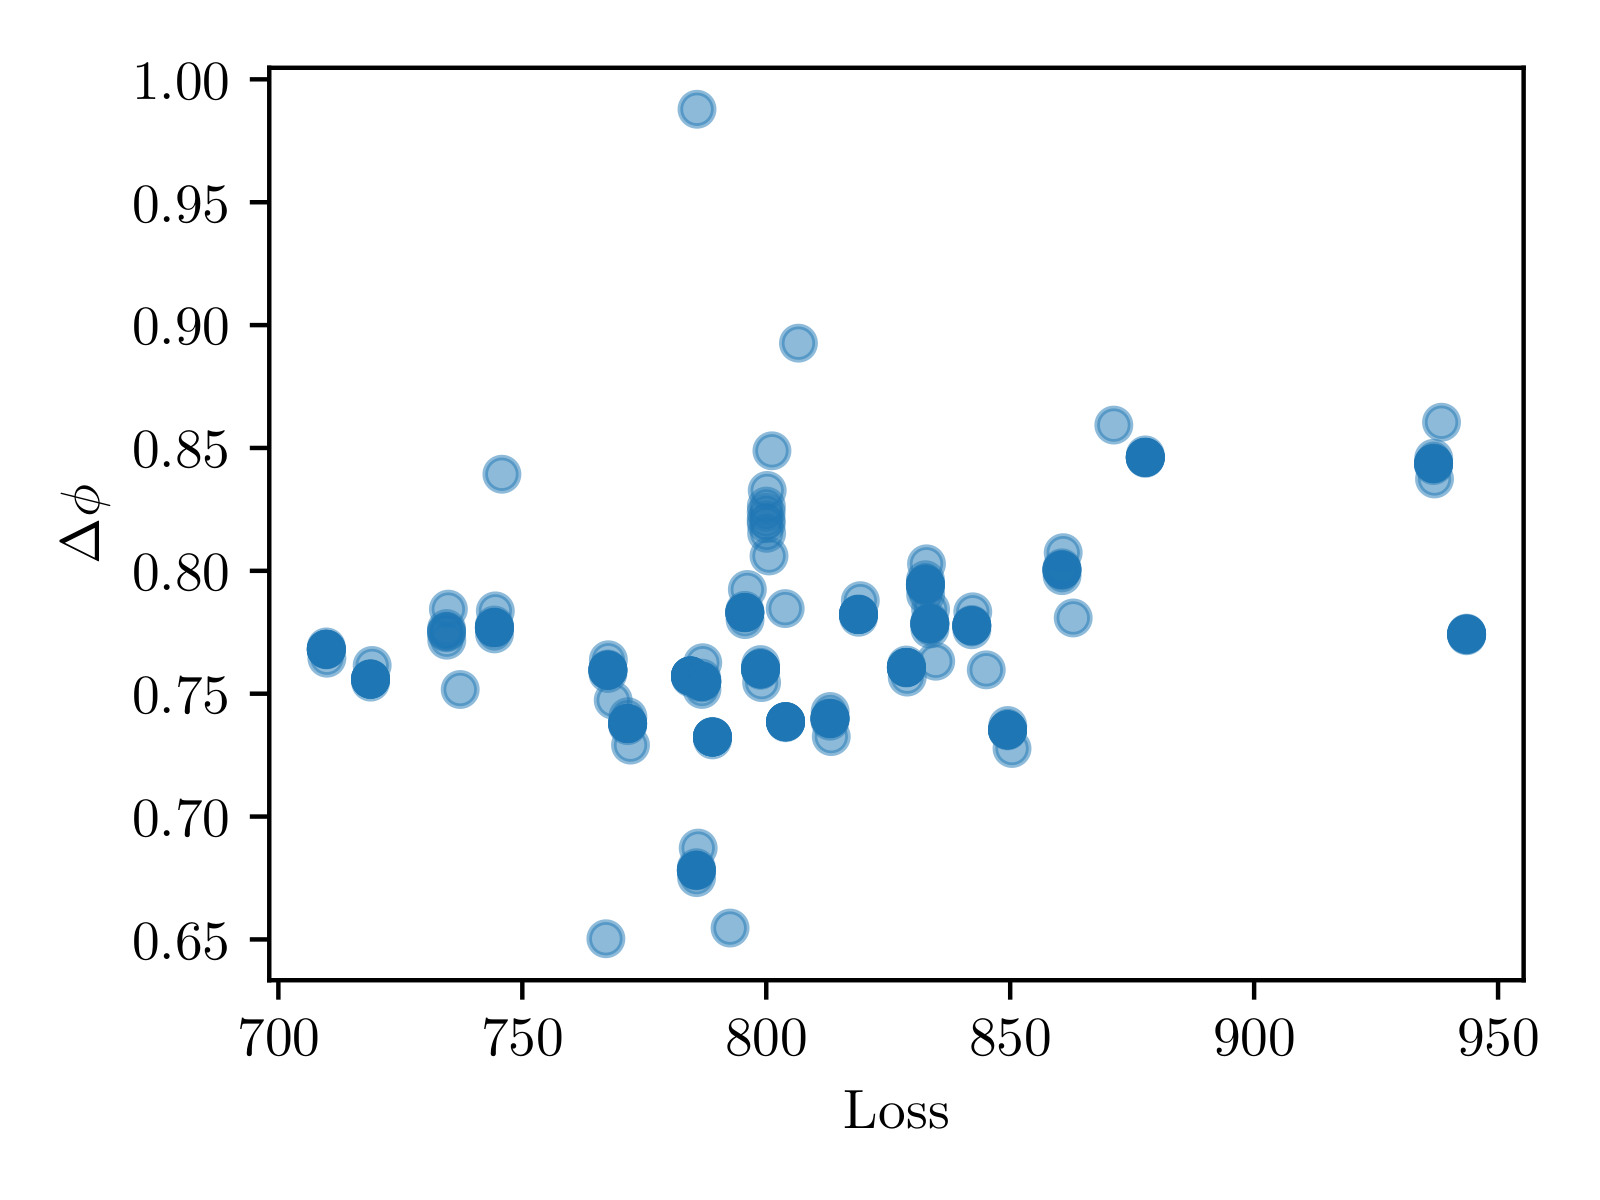
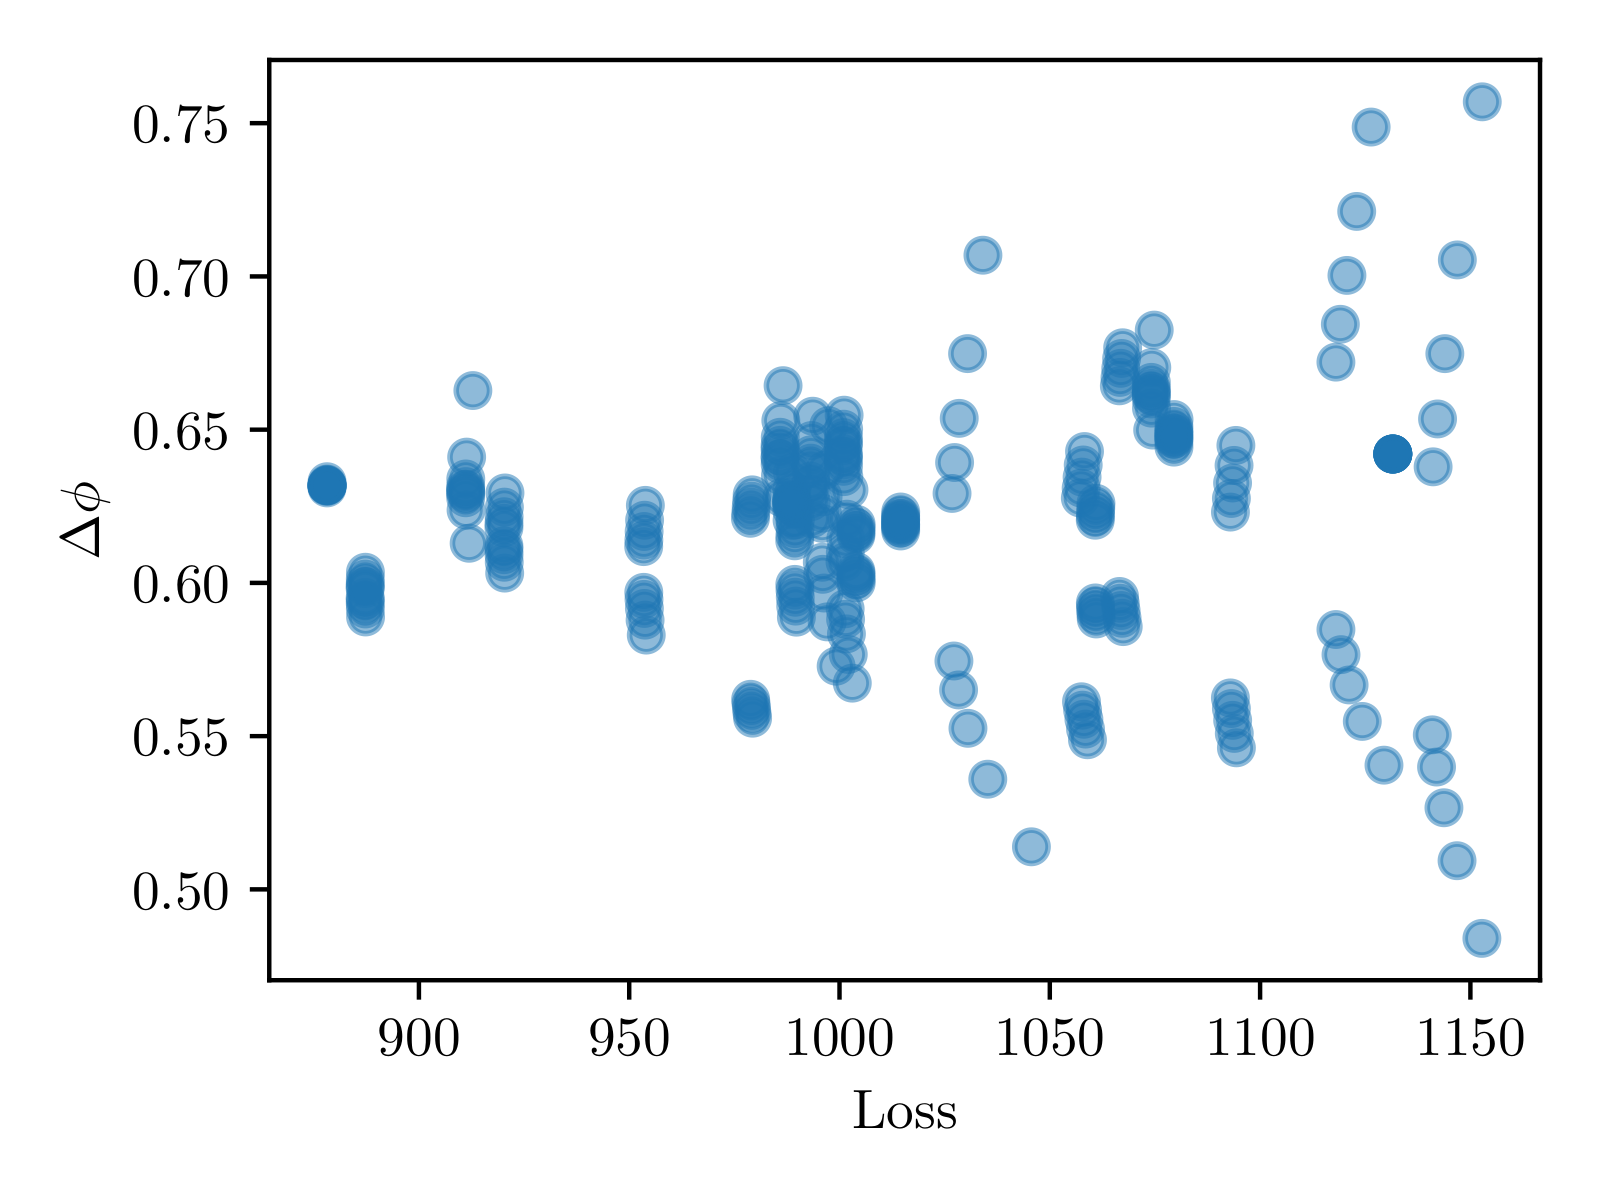
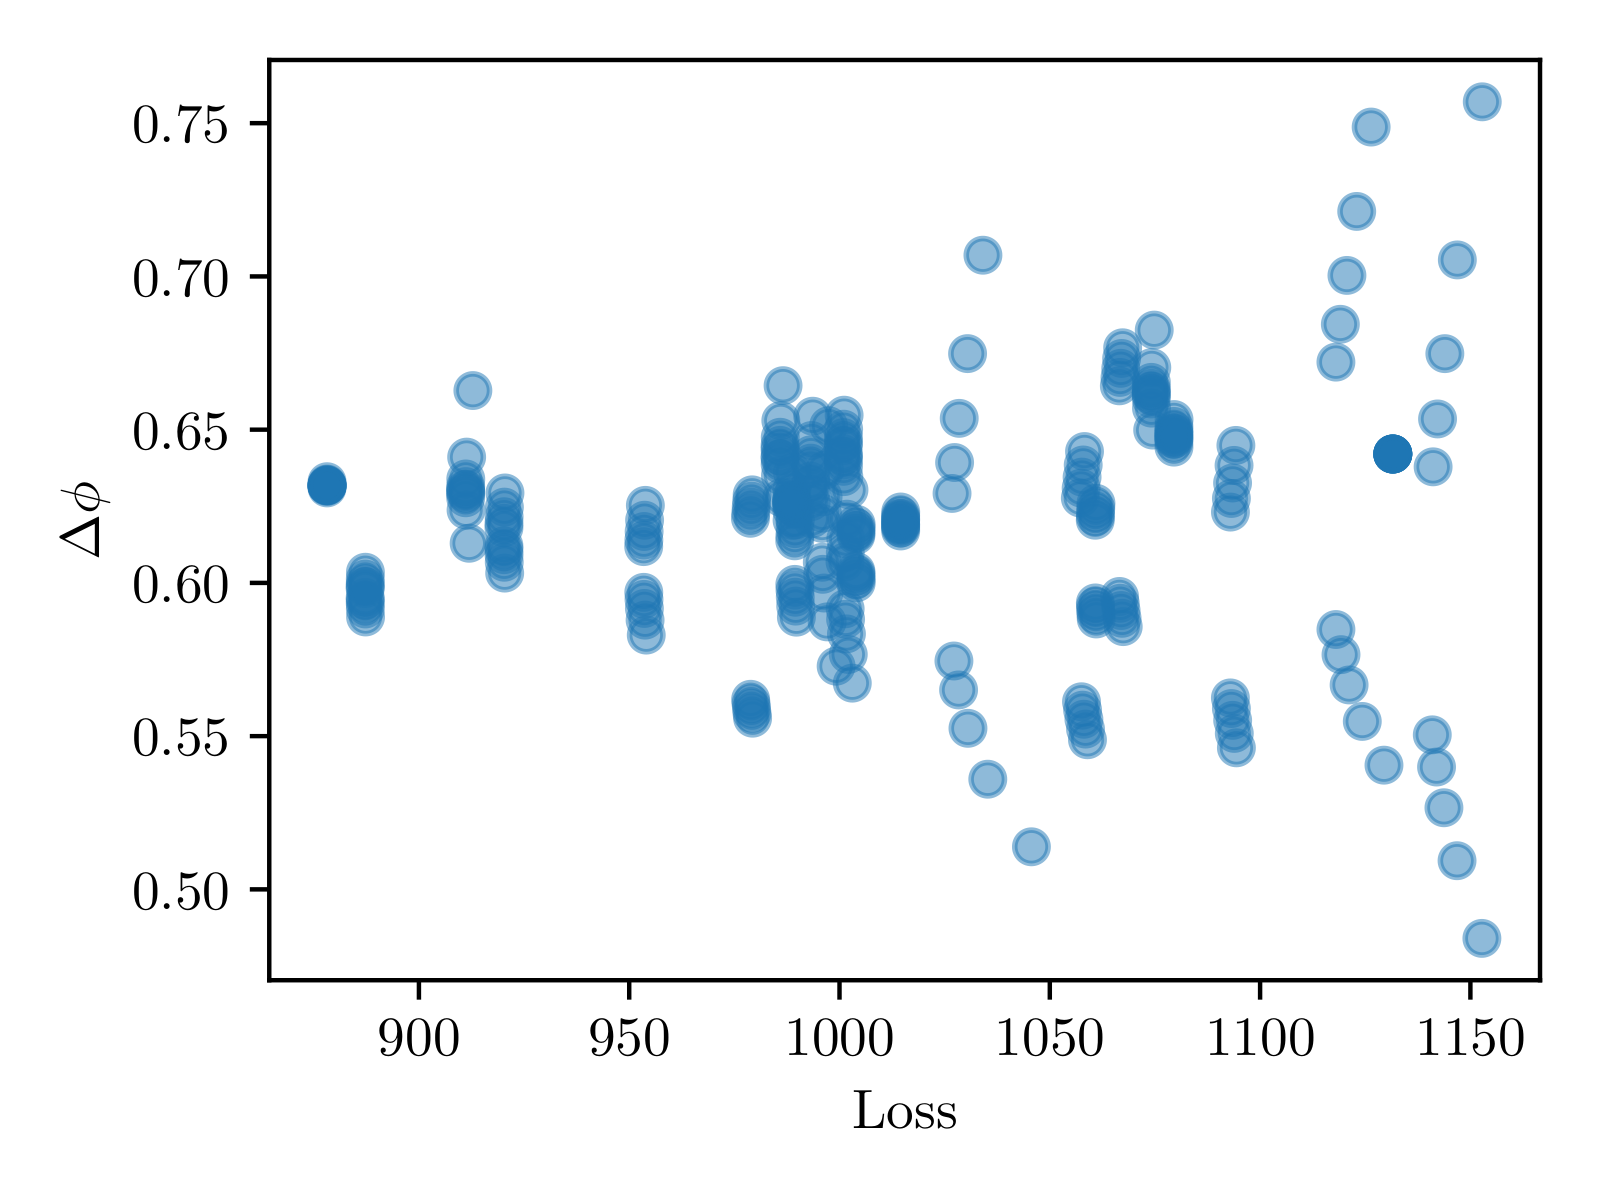

In [6]:
def plot(x, file_name):
    with ftl.FigContext():
        fig, ax = plt.subplots()

        ax.scatter(x[0], x[1], alpha=.5)
        ax.set_xlabel('Loss')
        ax.set_ylabel('$\Delta\phi$')

        return ftl.save_fig(fig, file_name)

ftl.img_grid([
    plot(loss[0], 'loss_vs_dphi0'),
    plot(loss[1], 'loss_vs_dphi1'),
    plot(loss[2], 'loss_vs_dphi2'),
    plot(loss[3], 'loss_vs_dphi3'),
], n_columns=2)

[Download loss0.png],[Download loss1.png]
[Download loss2.png],[Download loss3.png]

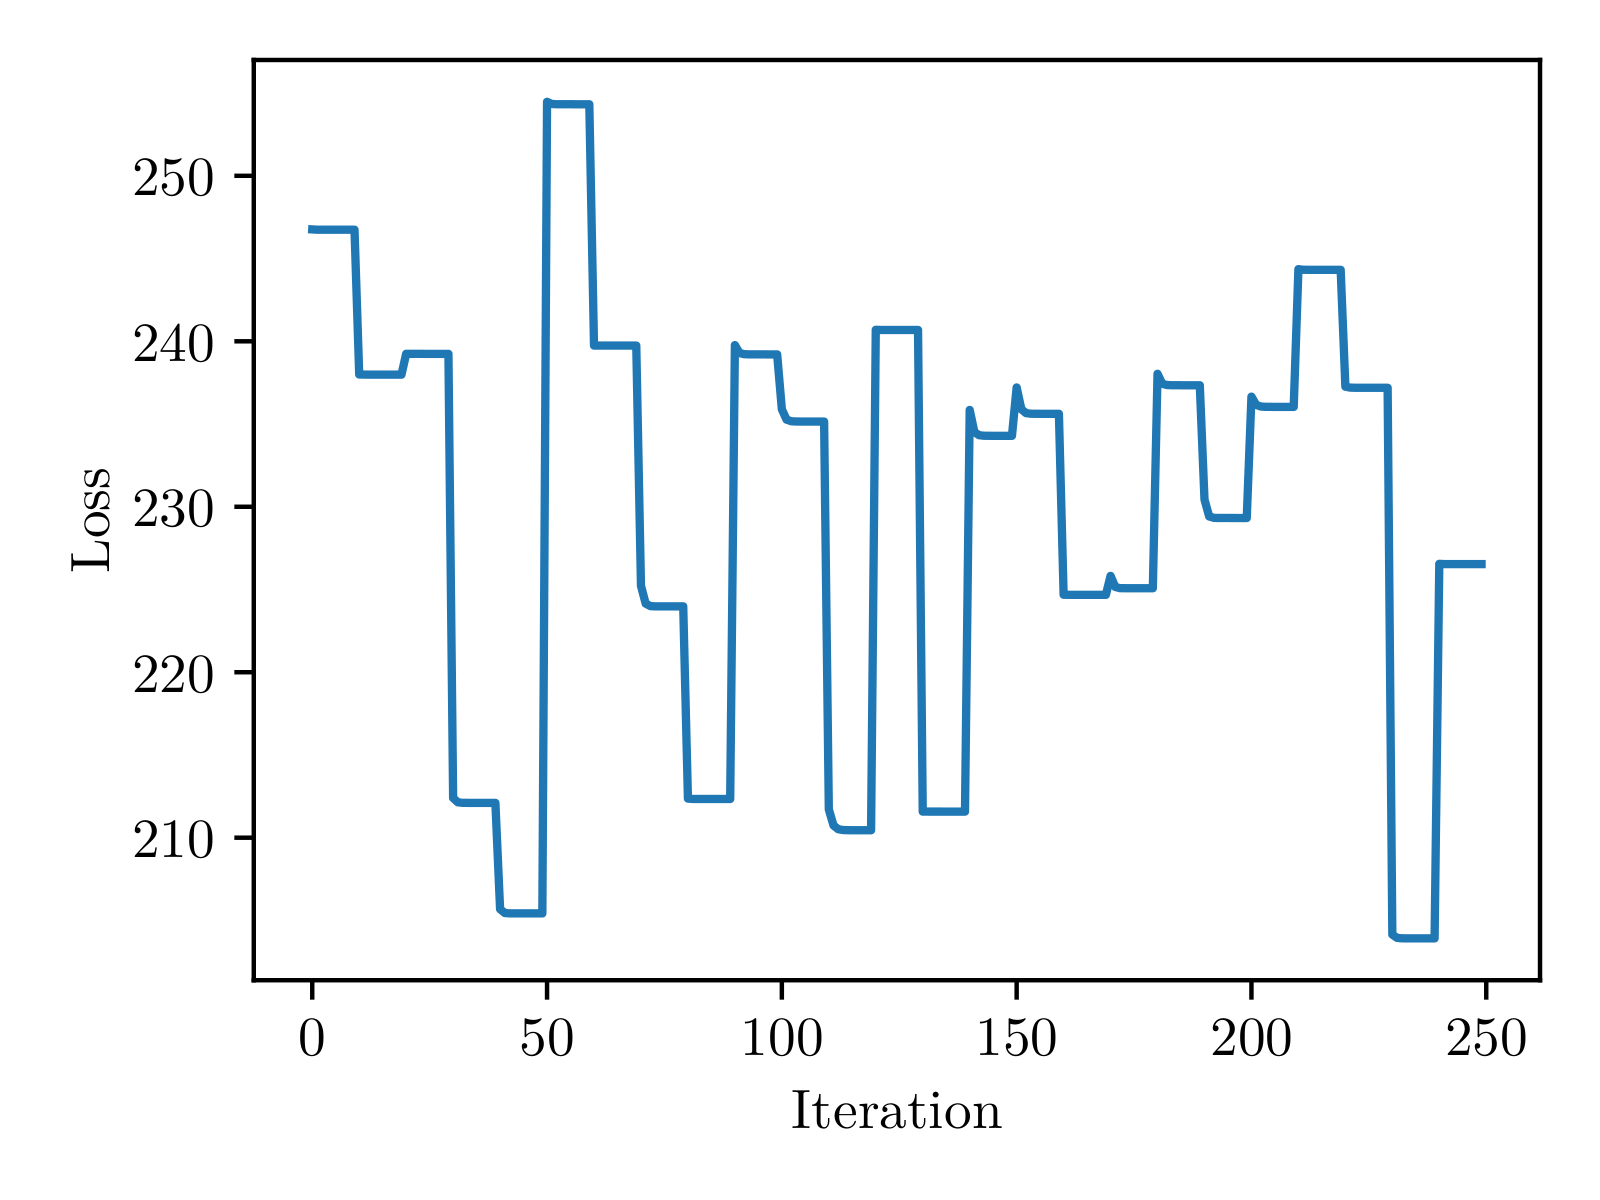
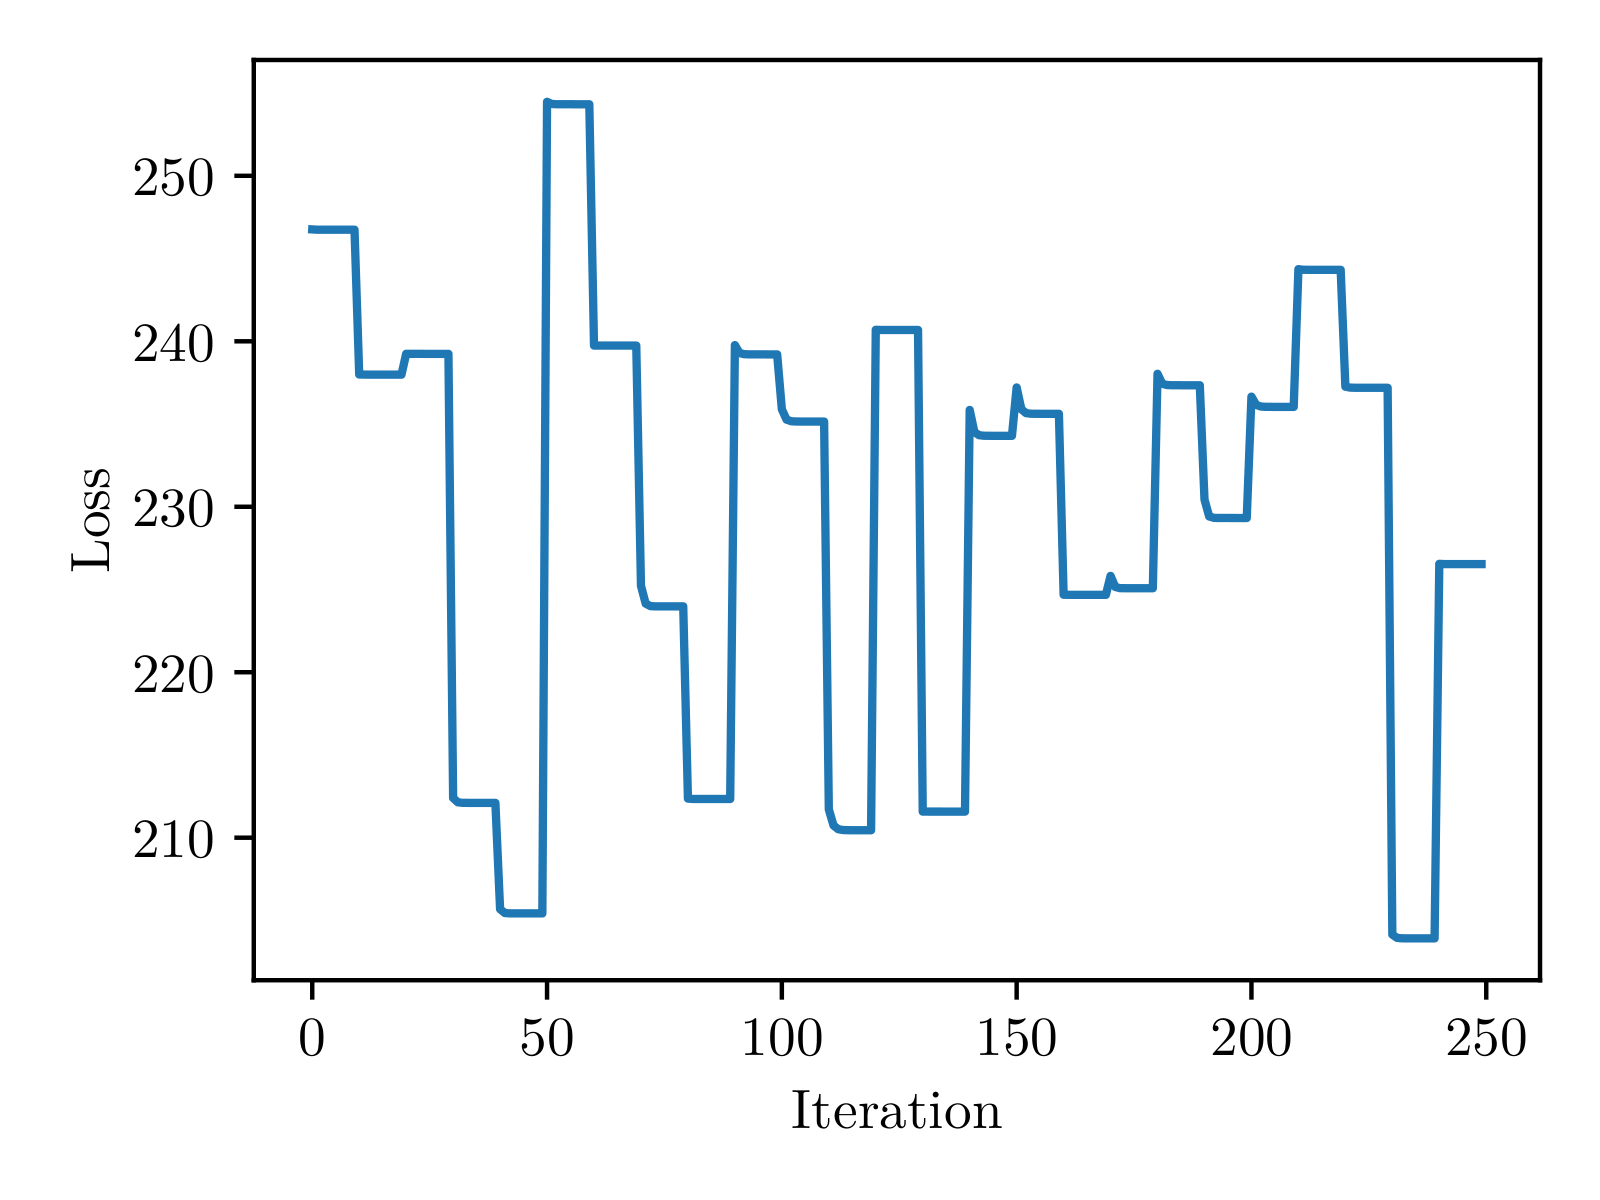
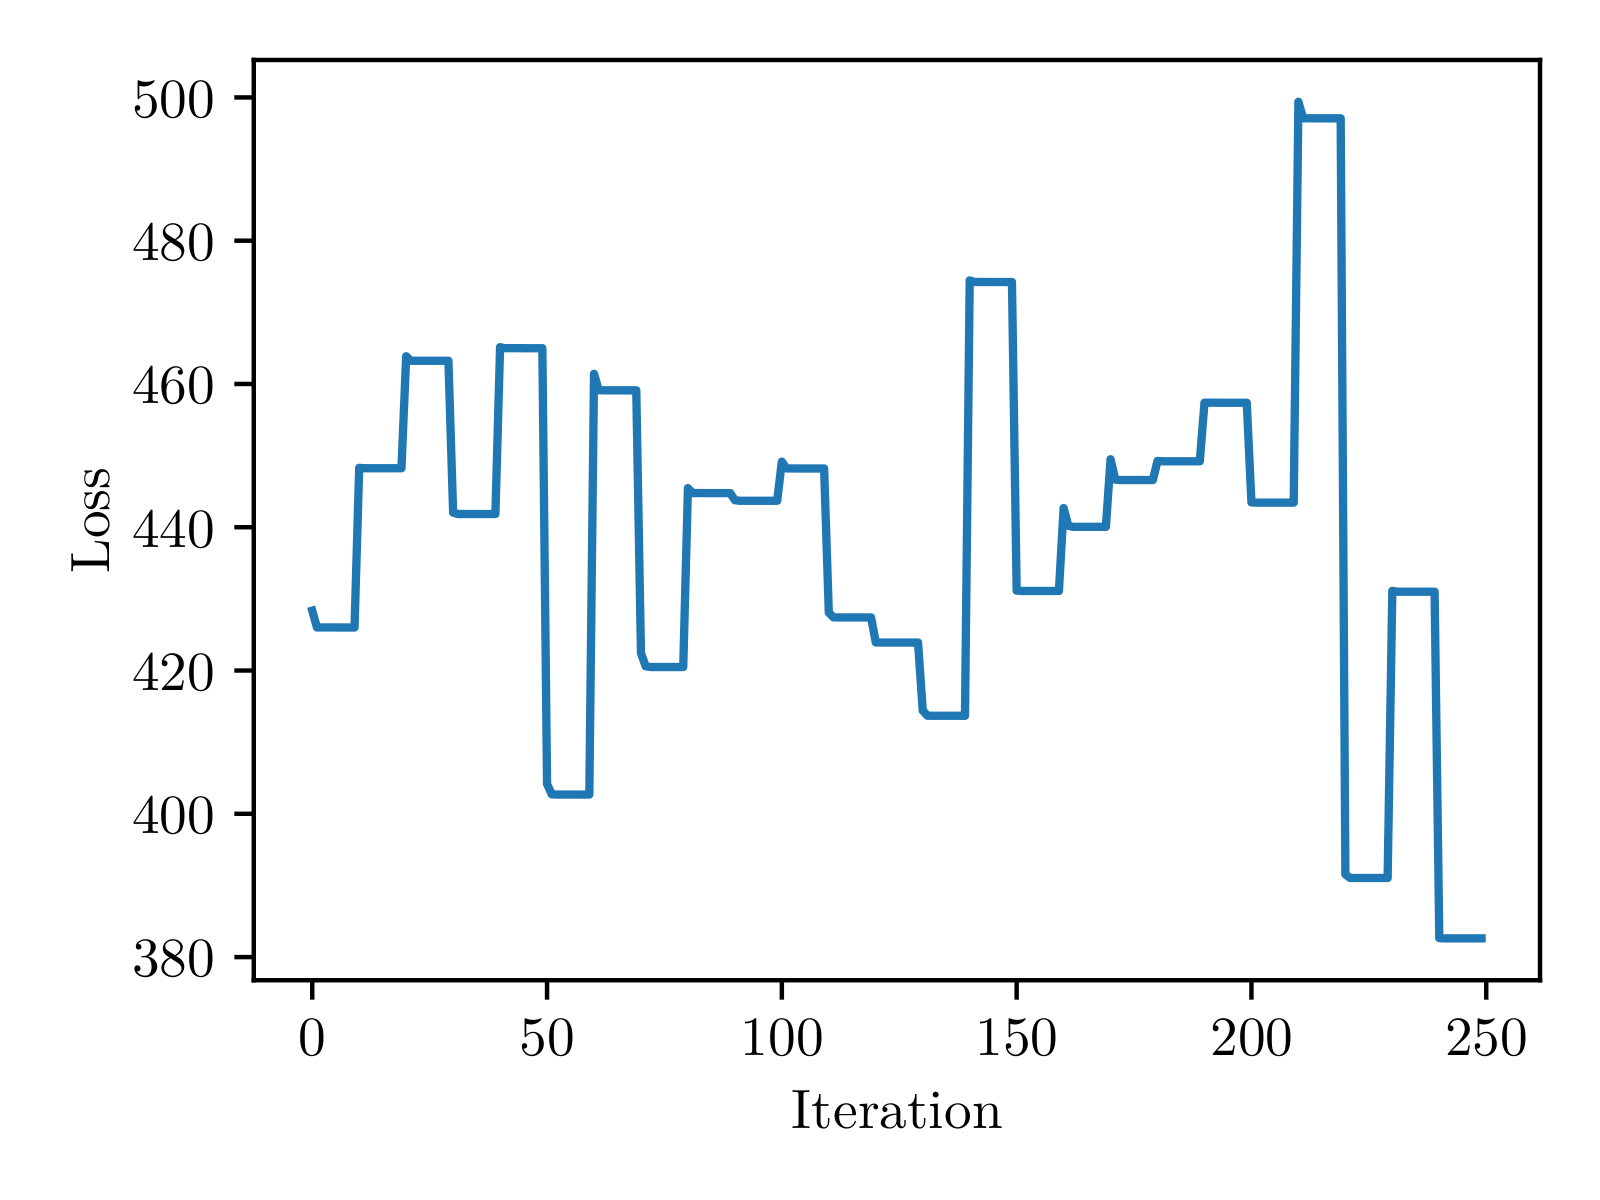
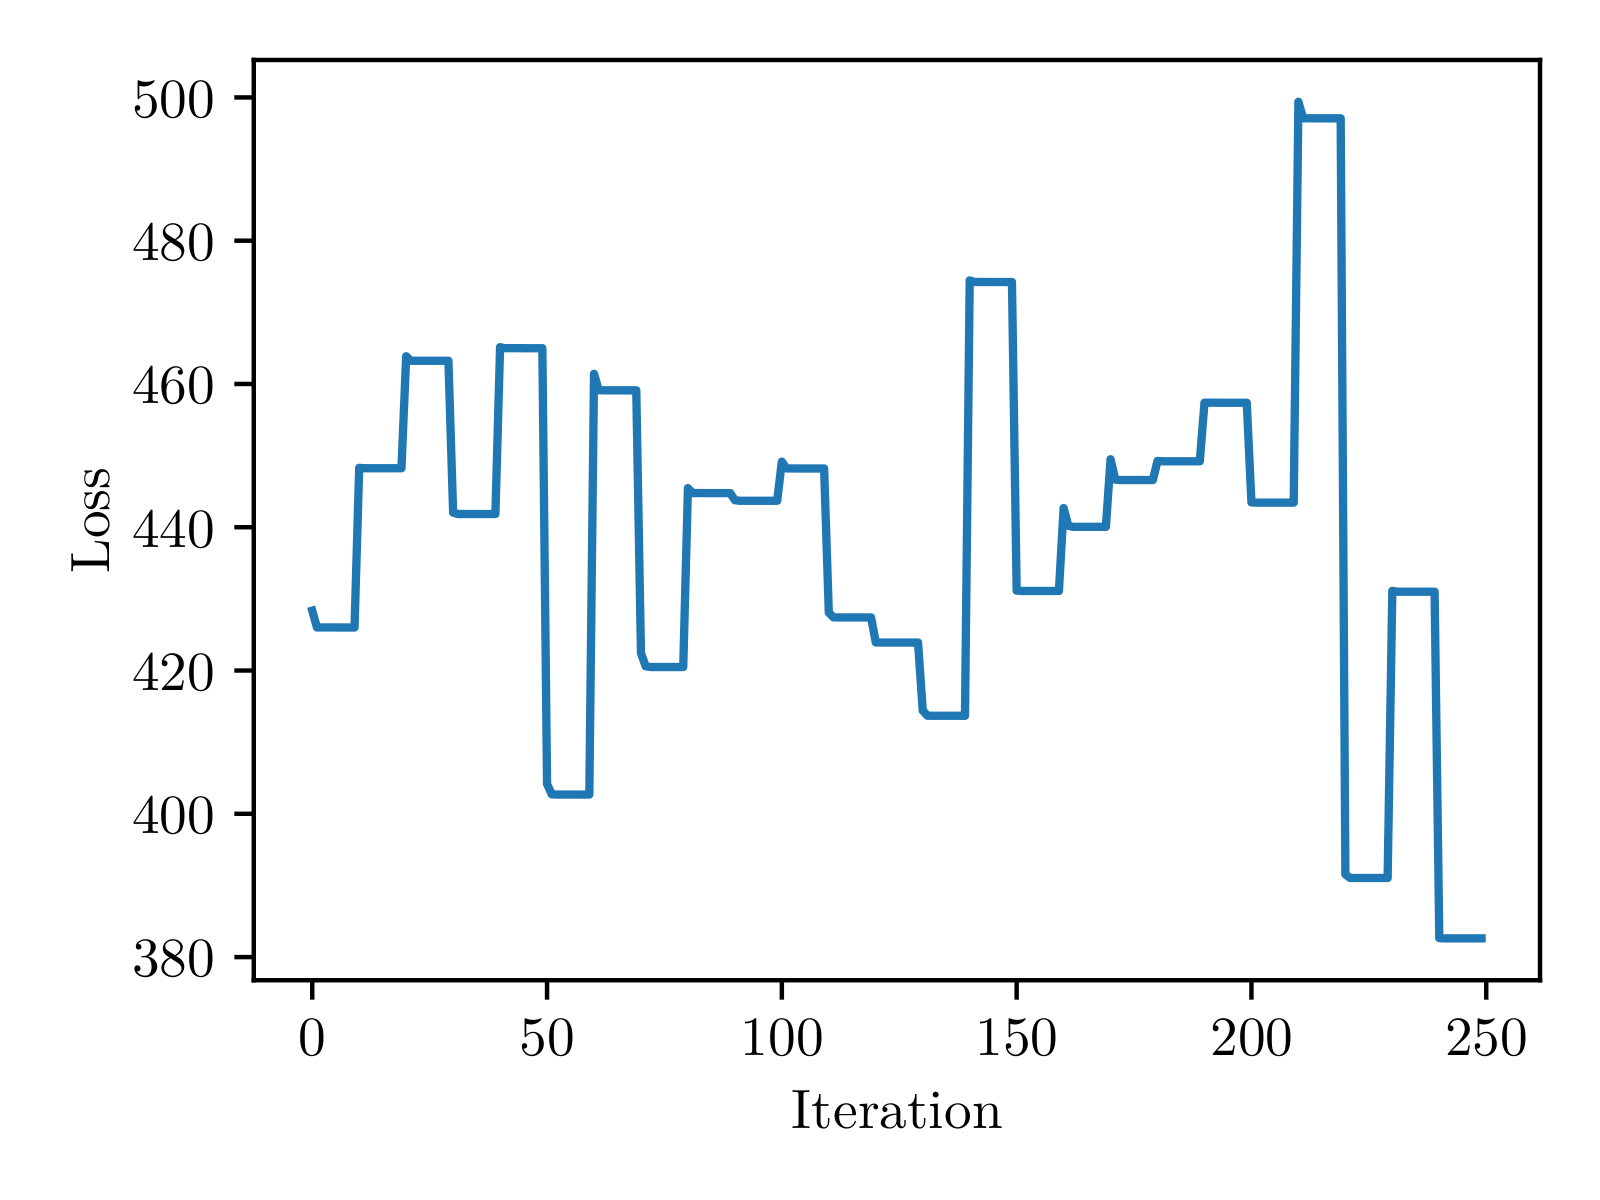
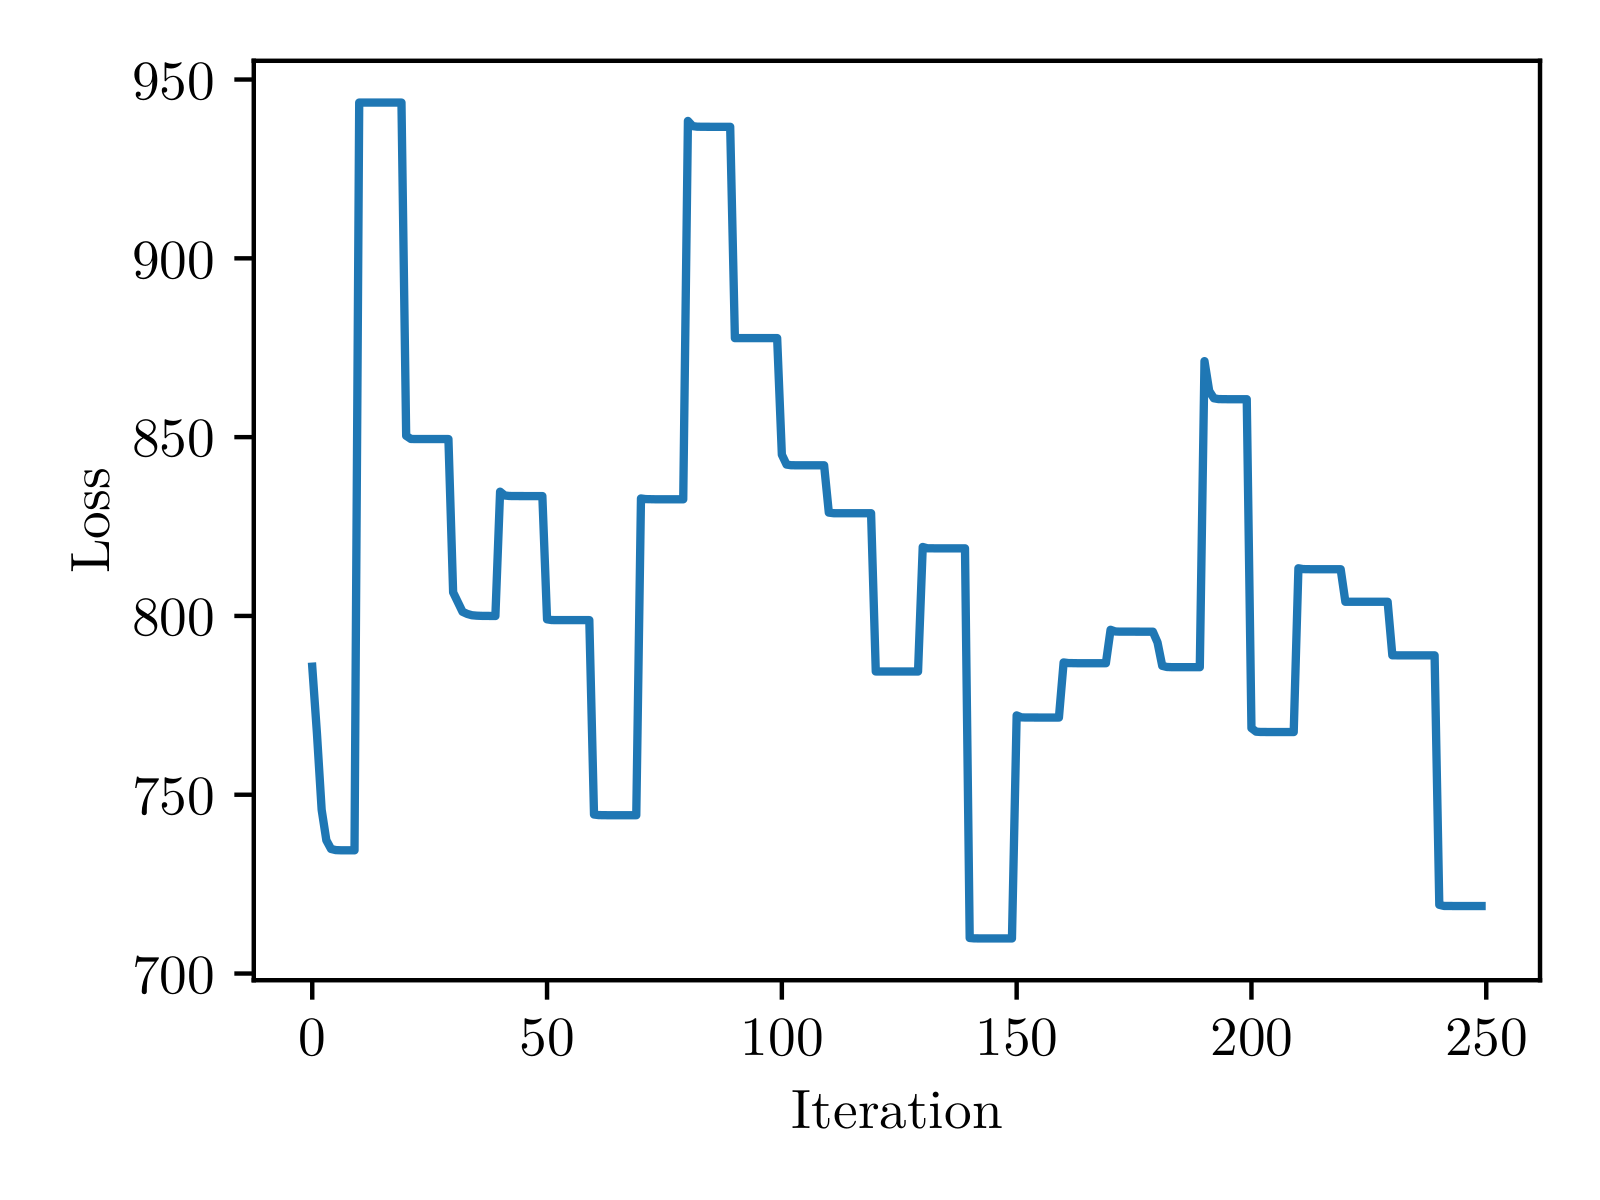
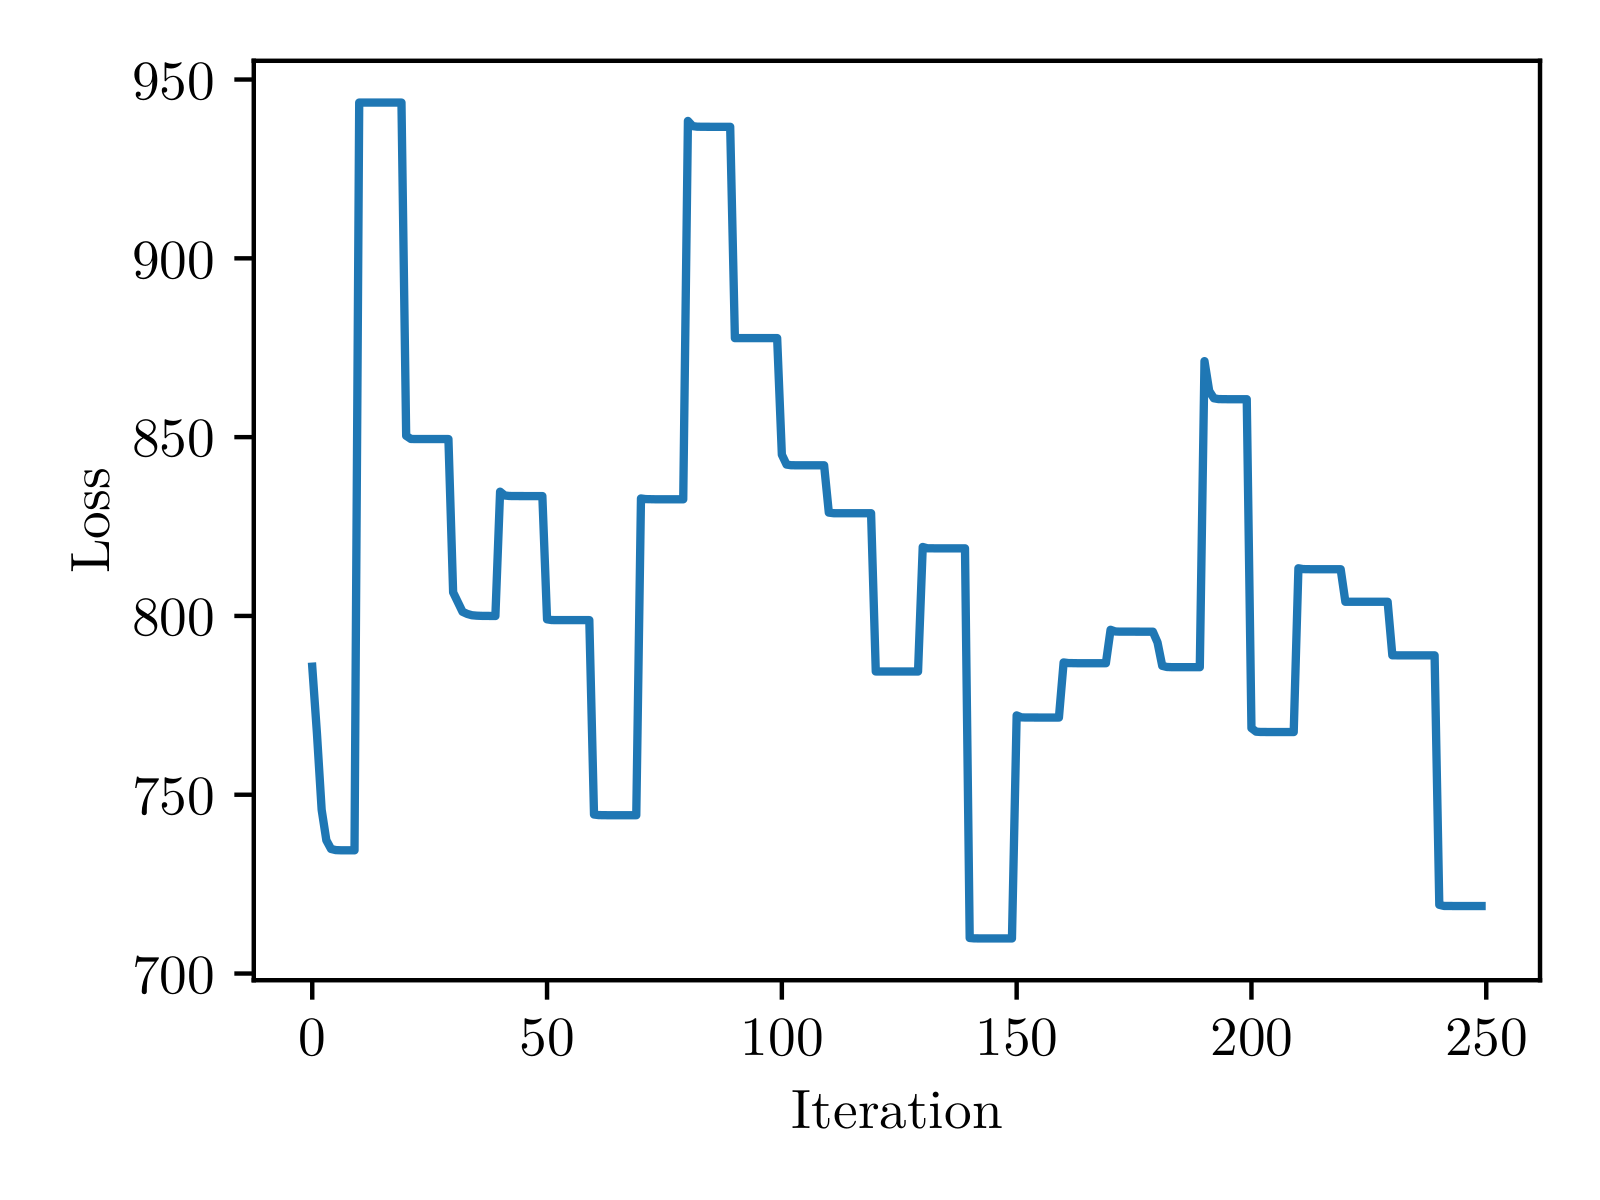
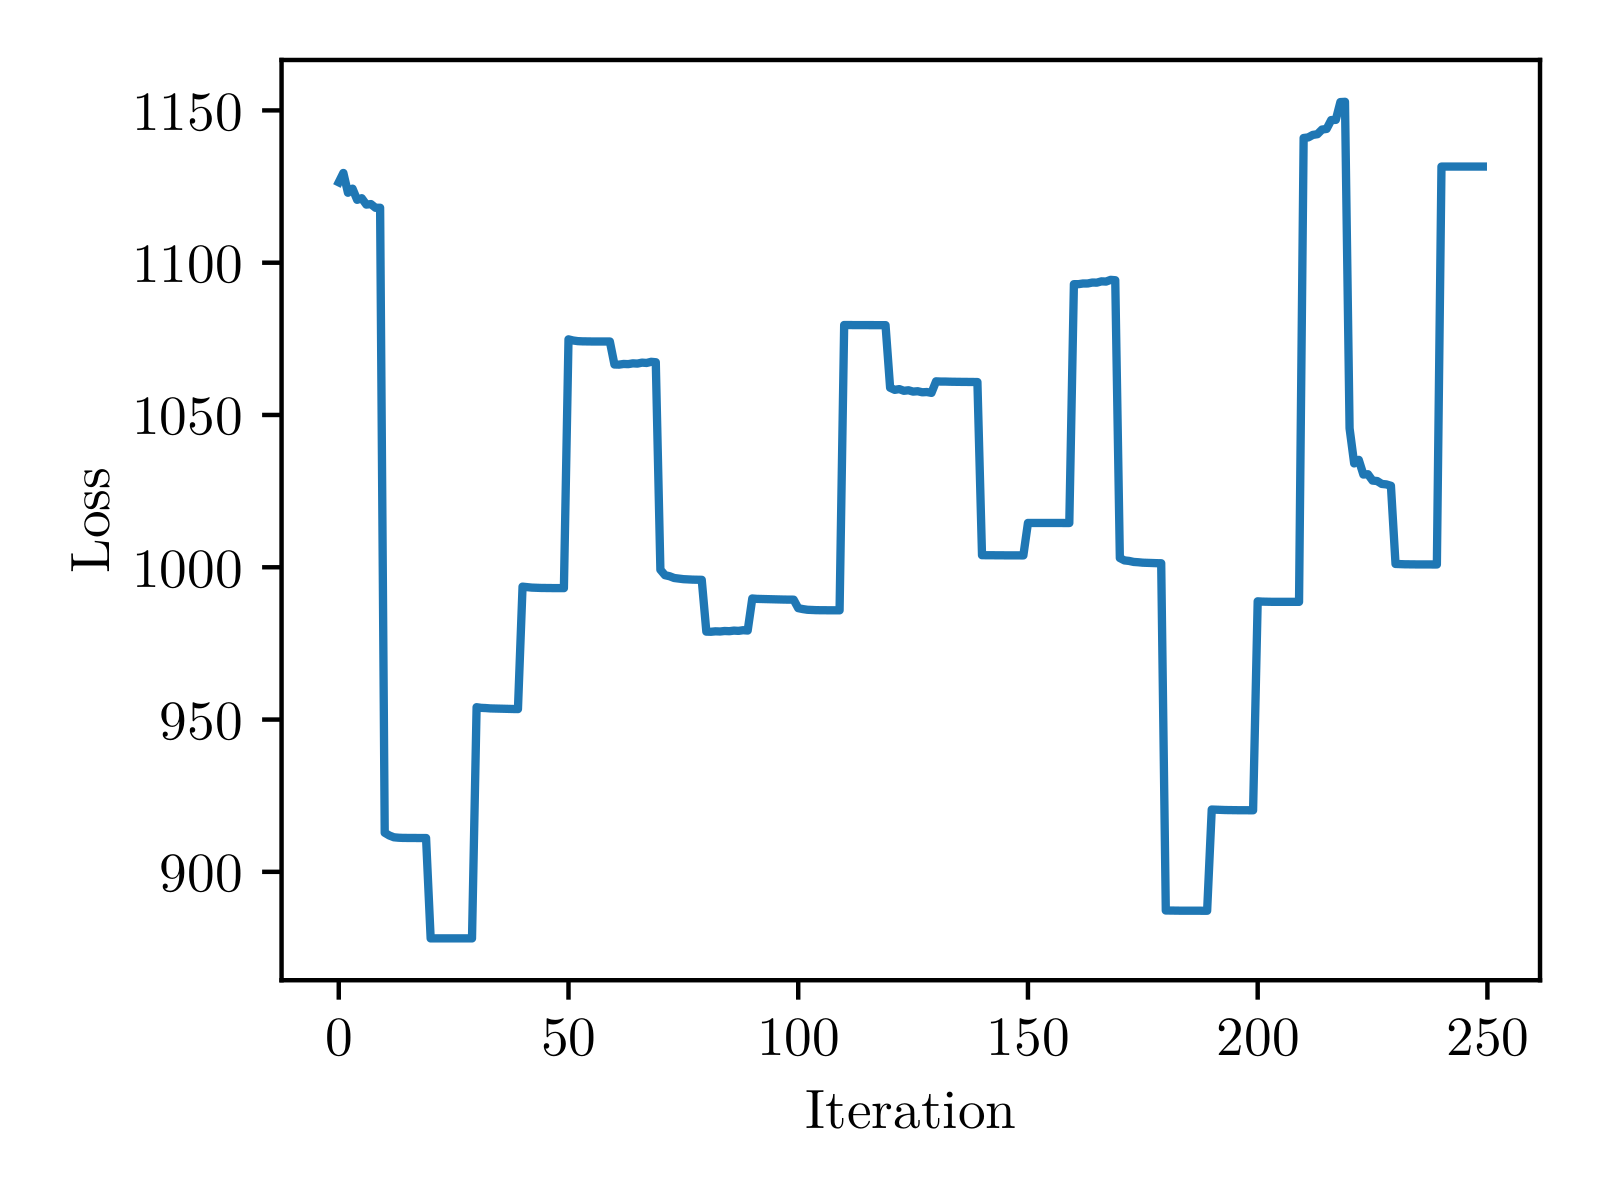
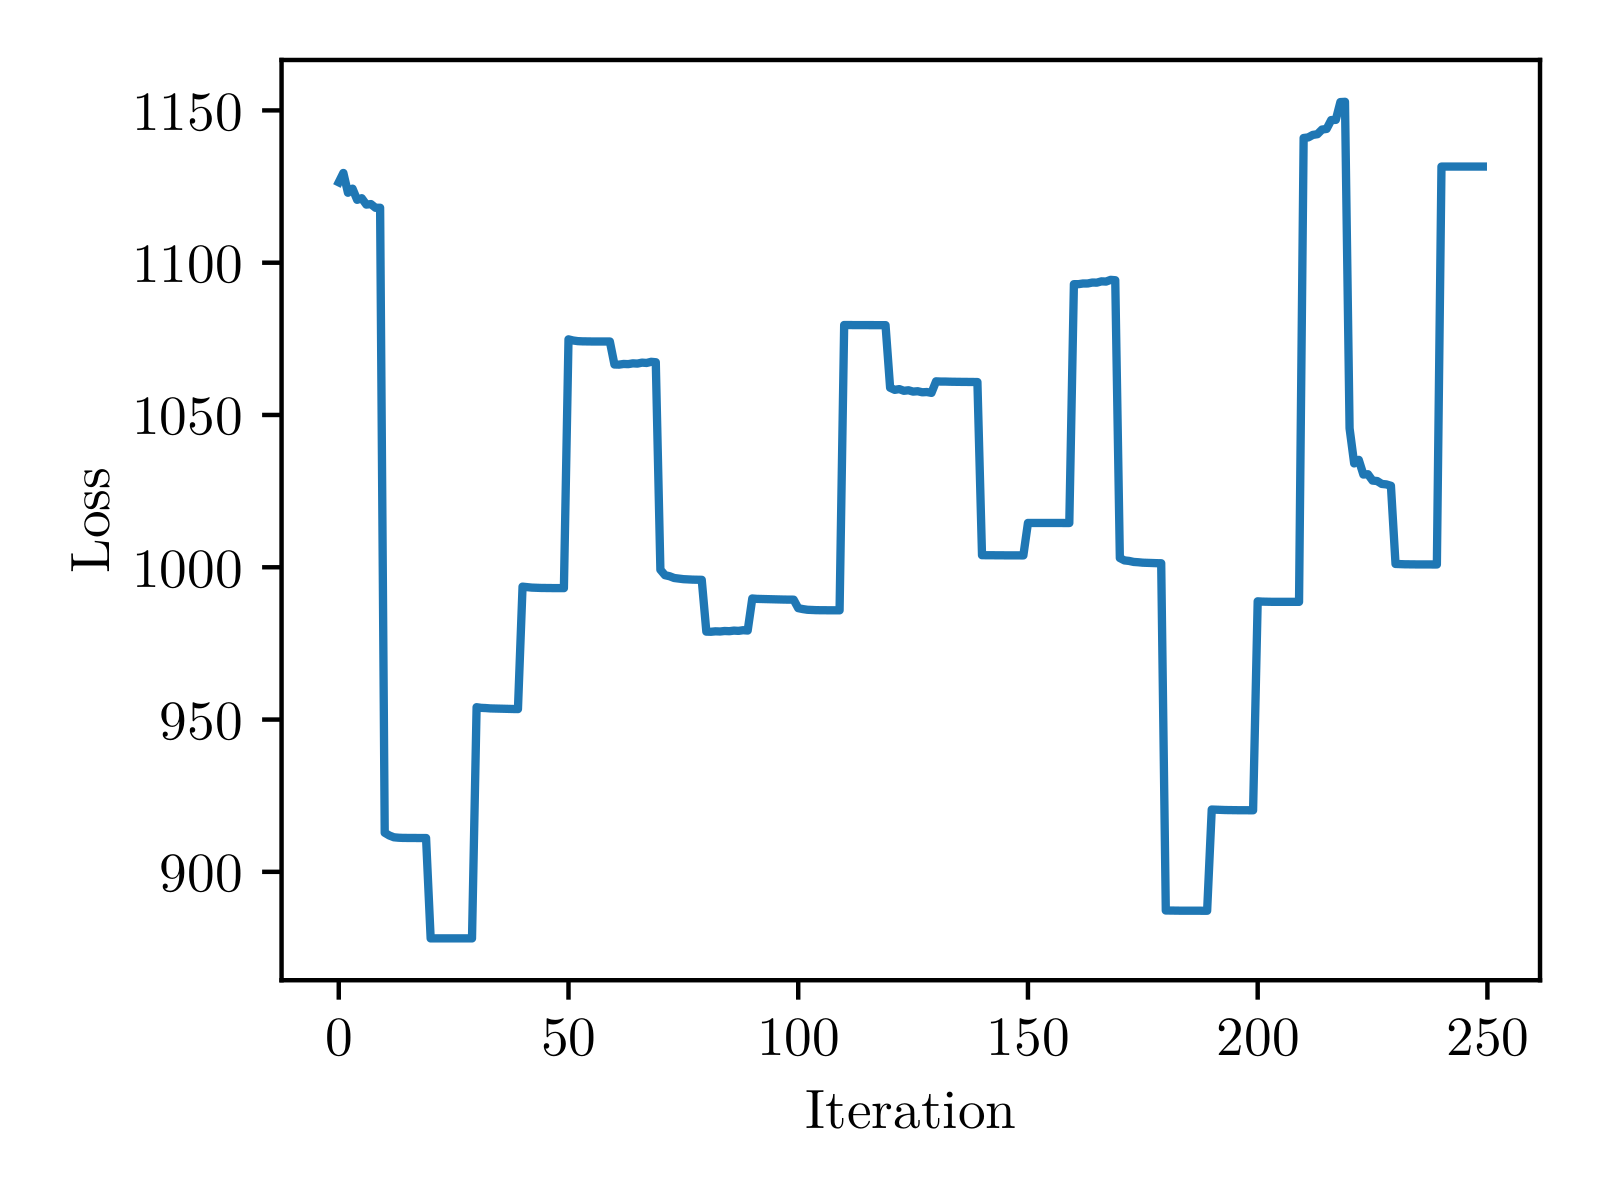

In [7]:
def plot(x, file_name):
    with ftl.FigContext():
        fig, ax = plt.subplots()

        ax.plot(x[0])
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')

        return ftl.save_fig(fig, file_name)

ftl.img_grid([
    plot(loss[0], 'loss0'),
    plot(loss[1], 'loss1'),
    plot(loss[2], 'loss2'),
    plot(loss[3], 'loss3'),
], n_columns=2)

In [8]:
phi_noise = torch.tensor([loss[i, :, np.argmin(loss[i][0])][1] for i in range(loss.shape[0])])
phi_noise

tensor([0.4820, 0.5949, 0.7681, 0.6316], dtype=torch.float64)

In [9]:
def predict(X, *, phi_noise):
    b, _, n_iter = X.shape

    ukf = UKF(phi_noise=phi_noise)
    X_pred = torch.empty((b, 3, n_iter))

    for i in range(n_iter):
        X_pred[:, :, i], _ = ukf.step(X[:, :, i])

    return X_pred

X_pred = predict(X, phi_noise=phi_noise)

In [10]:
def plot(x, file_name, plt_func, *plt_args, **plt_kwargs):
    with ftl.FigContext():
        fig, ax = plt.subplots()

        b, _, _ = x.shape
        for i in range(b):
            getattr(ax, plt_func)(x[i, 0], x[i, 1], *plt_args, **plt_kwargs)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')

        ax.set_xlim(-35., 40.)
        ax.set_ylim(-45., 25.)

        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, 10))

        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, 10))

        ax.grid()

        return ftl.save_fig(fig, file_name)

In [11]:
plot(X_gt, 'gt', 'plot', '-')

Output(outputs=({'output_type': 'display_data', 'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkAAAASwCAIAAAA…

In [12]:
plot(X, 'data', 'scatter', s=1., alpha=.1)

Output(outputs=({'output_type': 'display_data', 'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkAAAASwCAIAAAA…

In [13]:
def plot(x_pred, x_gt, file_name):
    with ftl.FigContext():
        fig, ax = plt.subplots()

        b, _, _ = x_pred.shape
        for i in range(b):
            ax.plot(x_pred[i, 0], x_pred[i, 1], '-', color=f'C{i}')
            ax.scatter(x_gt[i, 0], x_gt[i, 1], s=15, alpha=.8, color='black')

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')

        ax.set_xlim(-35., 40.)
        ax.set_ylim(-45., 25.)

        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, 10))

        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, 10))

        ax.grid()

        return ftl.save_fig(fig, file_name)

plot(X_pred[:, :, 120:150], X[:, :, 120:150], 'ukf')

Output(outputs=({'output_type': 'display_data', 'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkAAAASwCAIAAAA…

In [14]:
def plot(x, file_name, ylabel):
    with ftl.FigContext():
        fig, ax = plt.subplots()

        b, n = x.shape
        t = np.arange(n)

        for i in range(b):
            ax.plot(t, x[i])

        ax.set_xlabel('$t$')
        ax.set_ylabel(ylabel)

        ax.grid()

        return ftl.save_fig(fig, file_name)

plot(X_pred[:, 2, 90:150], 'phi', '$\phi$')

Output(outputs=({'output_type': 'display_data', 'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAABkAAAASwCAIAAAA…

In [15]:
def plot(x_measured, x_pred, file_name):
    with ftl.FigContext():
        fig, ax = plt.subplots()

        _, n1 = x_measured.shape
        _, n2 = x_pred.shape
        n = min(n1, n2)

        res = x_measured[:, :n] - x_pred[:, :n]
        b, _ = res.shape

        for i in range(b):
            ax.plot(res[i])

        ax.set_xlabel('$t$')
        ax.set_ylabel('measured $-$ predicted')

        ax.grid()

        return ftl.save_fig(fig, file_name)

[Download res_x.png],[Download res_y.png]

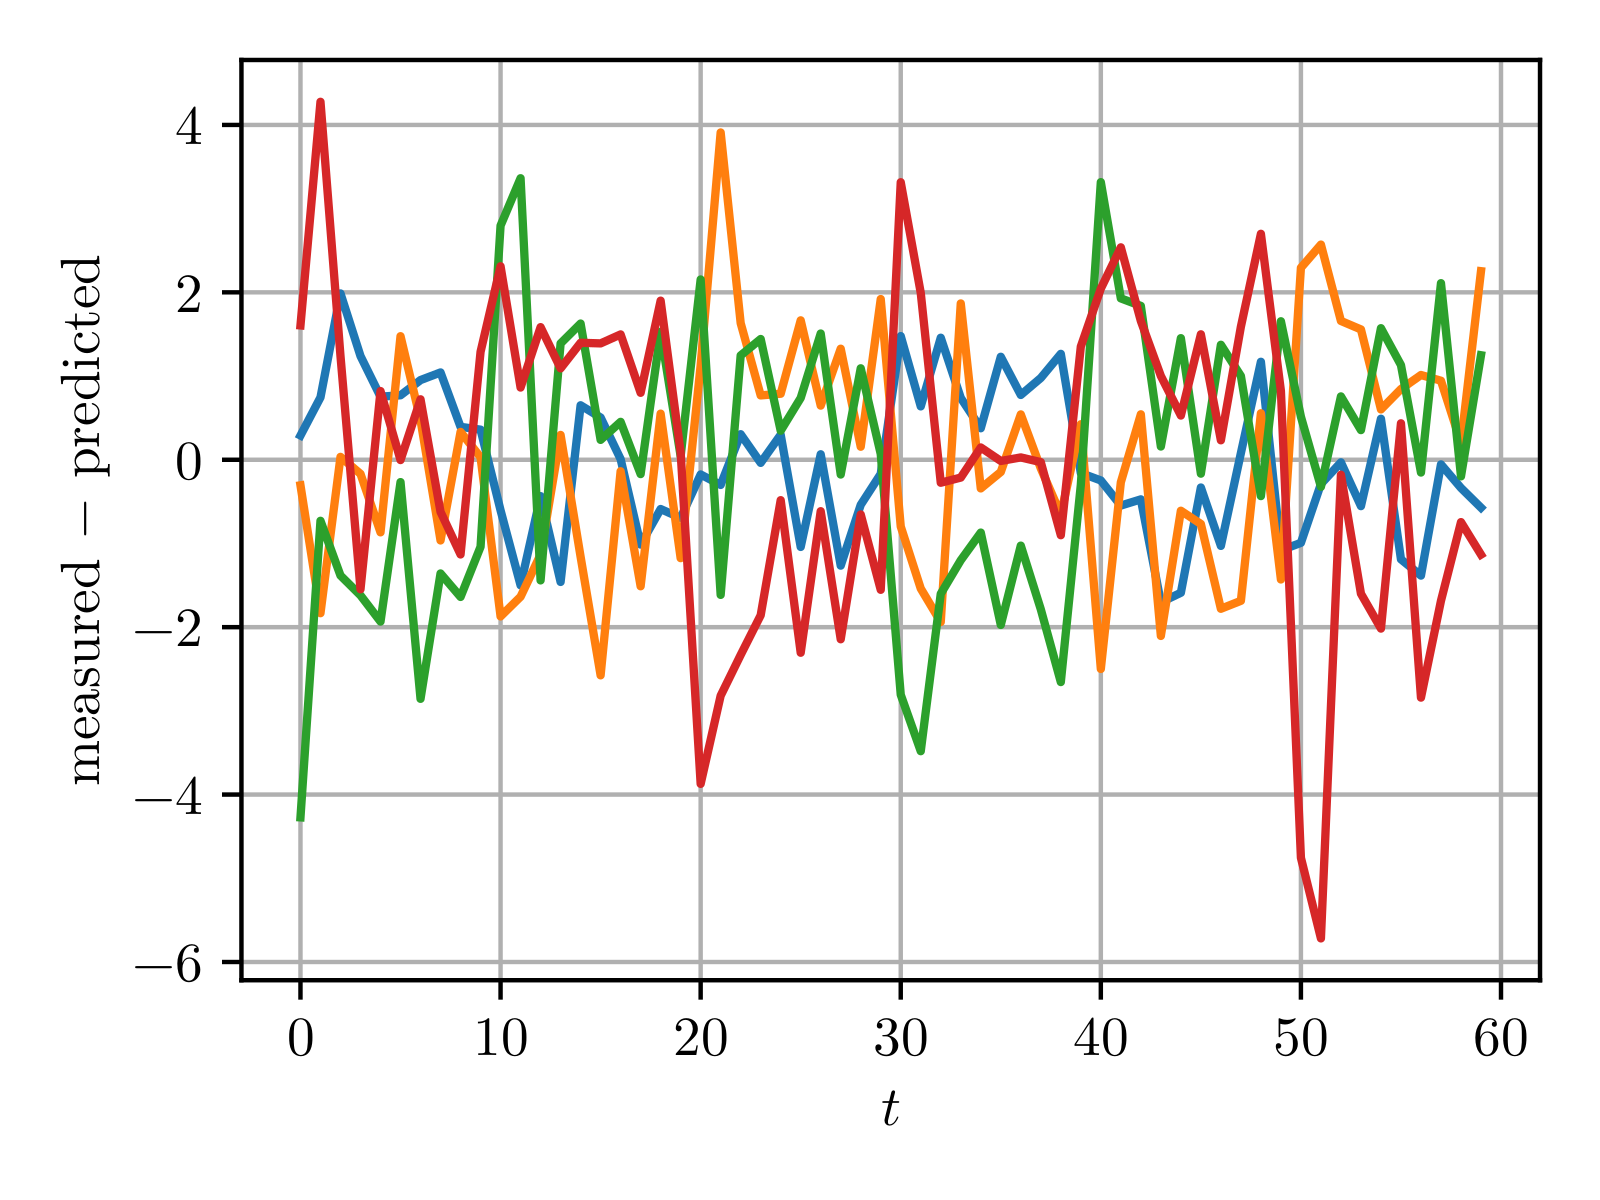
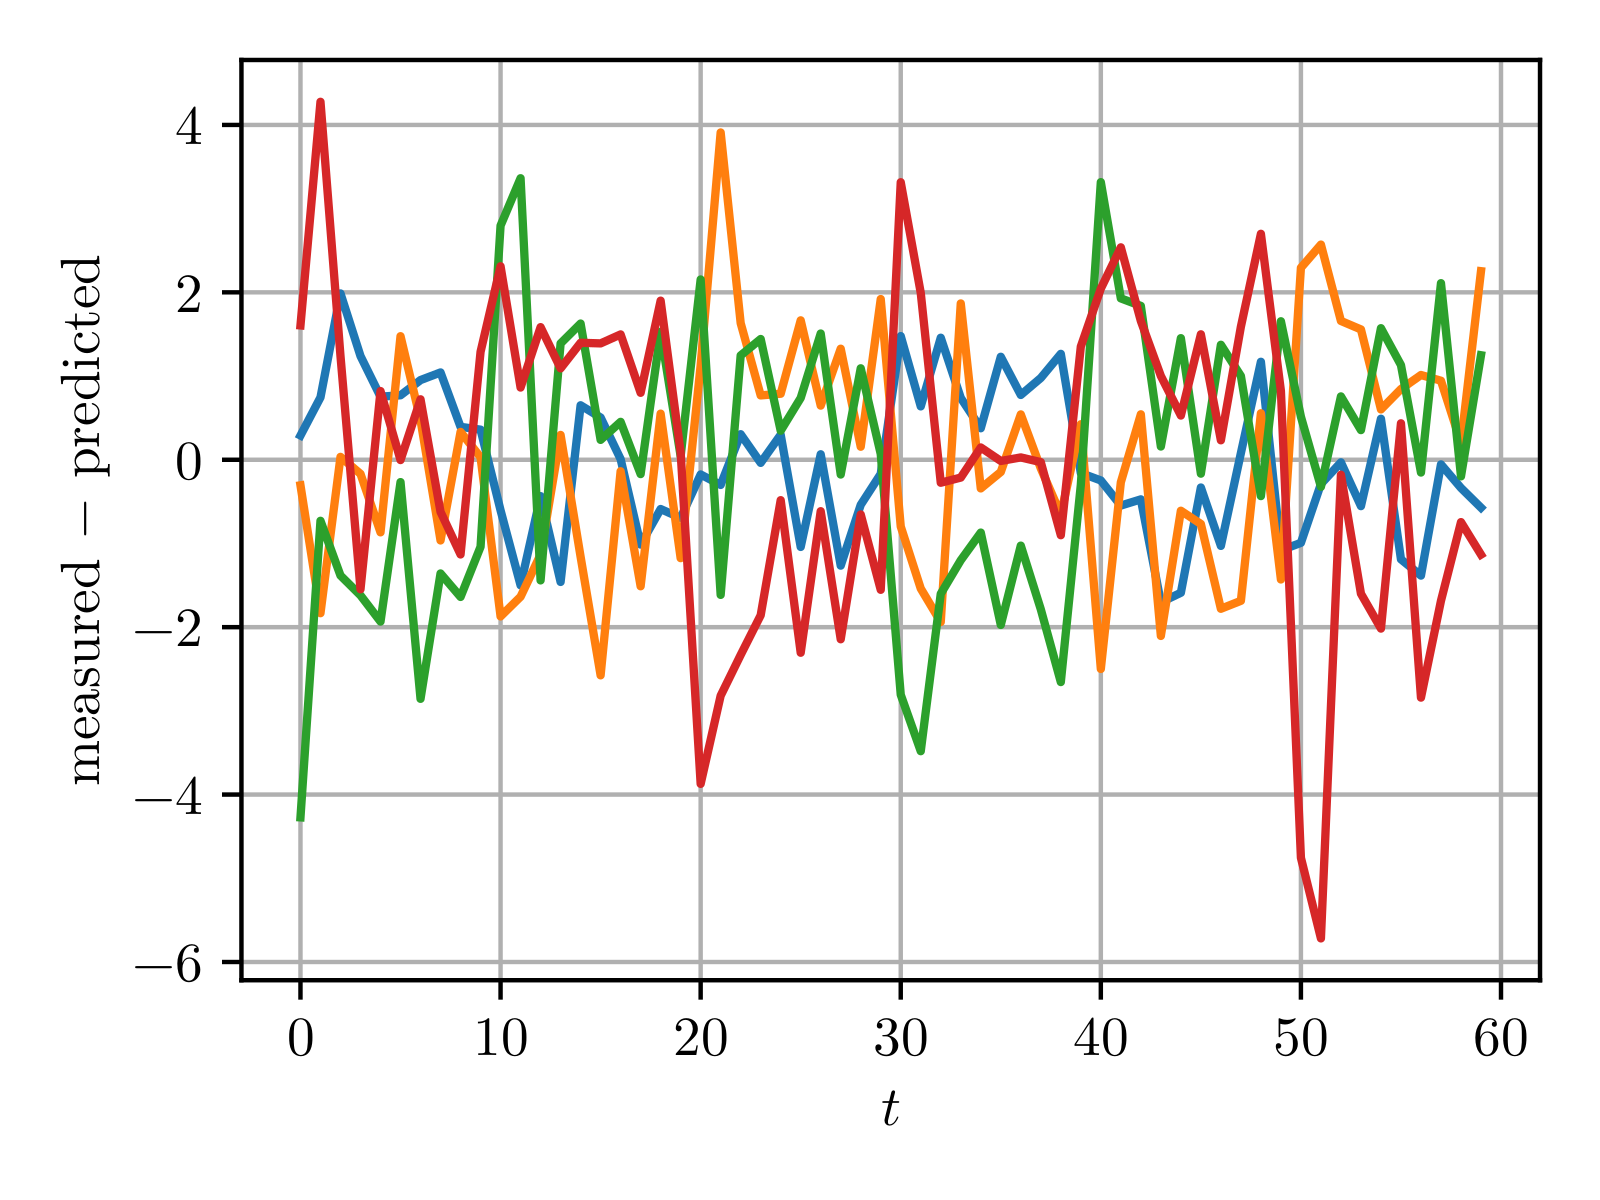
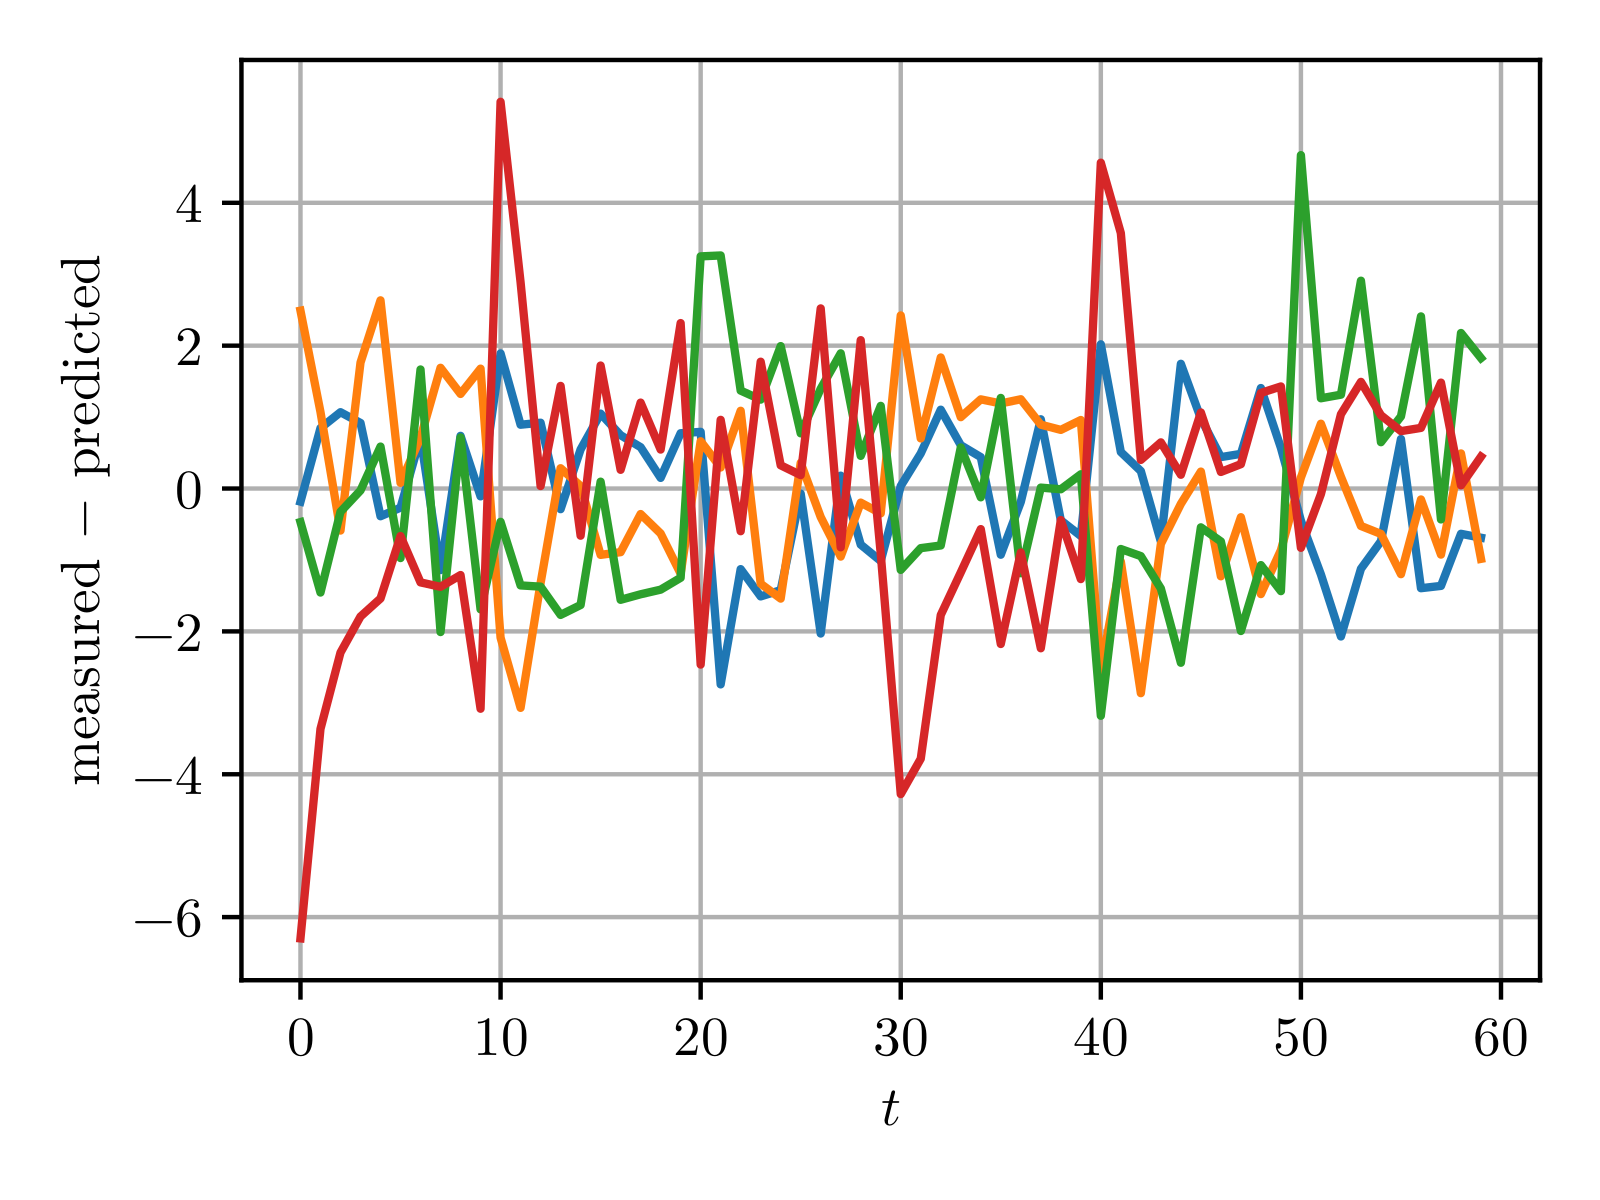
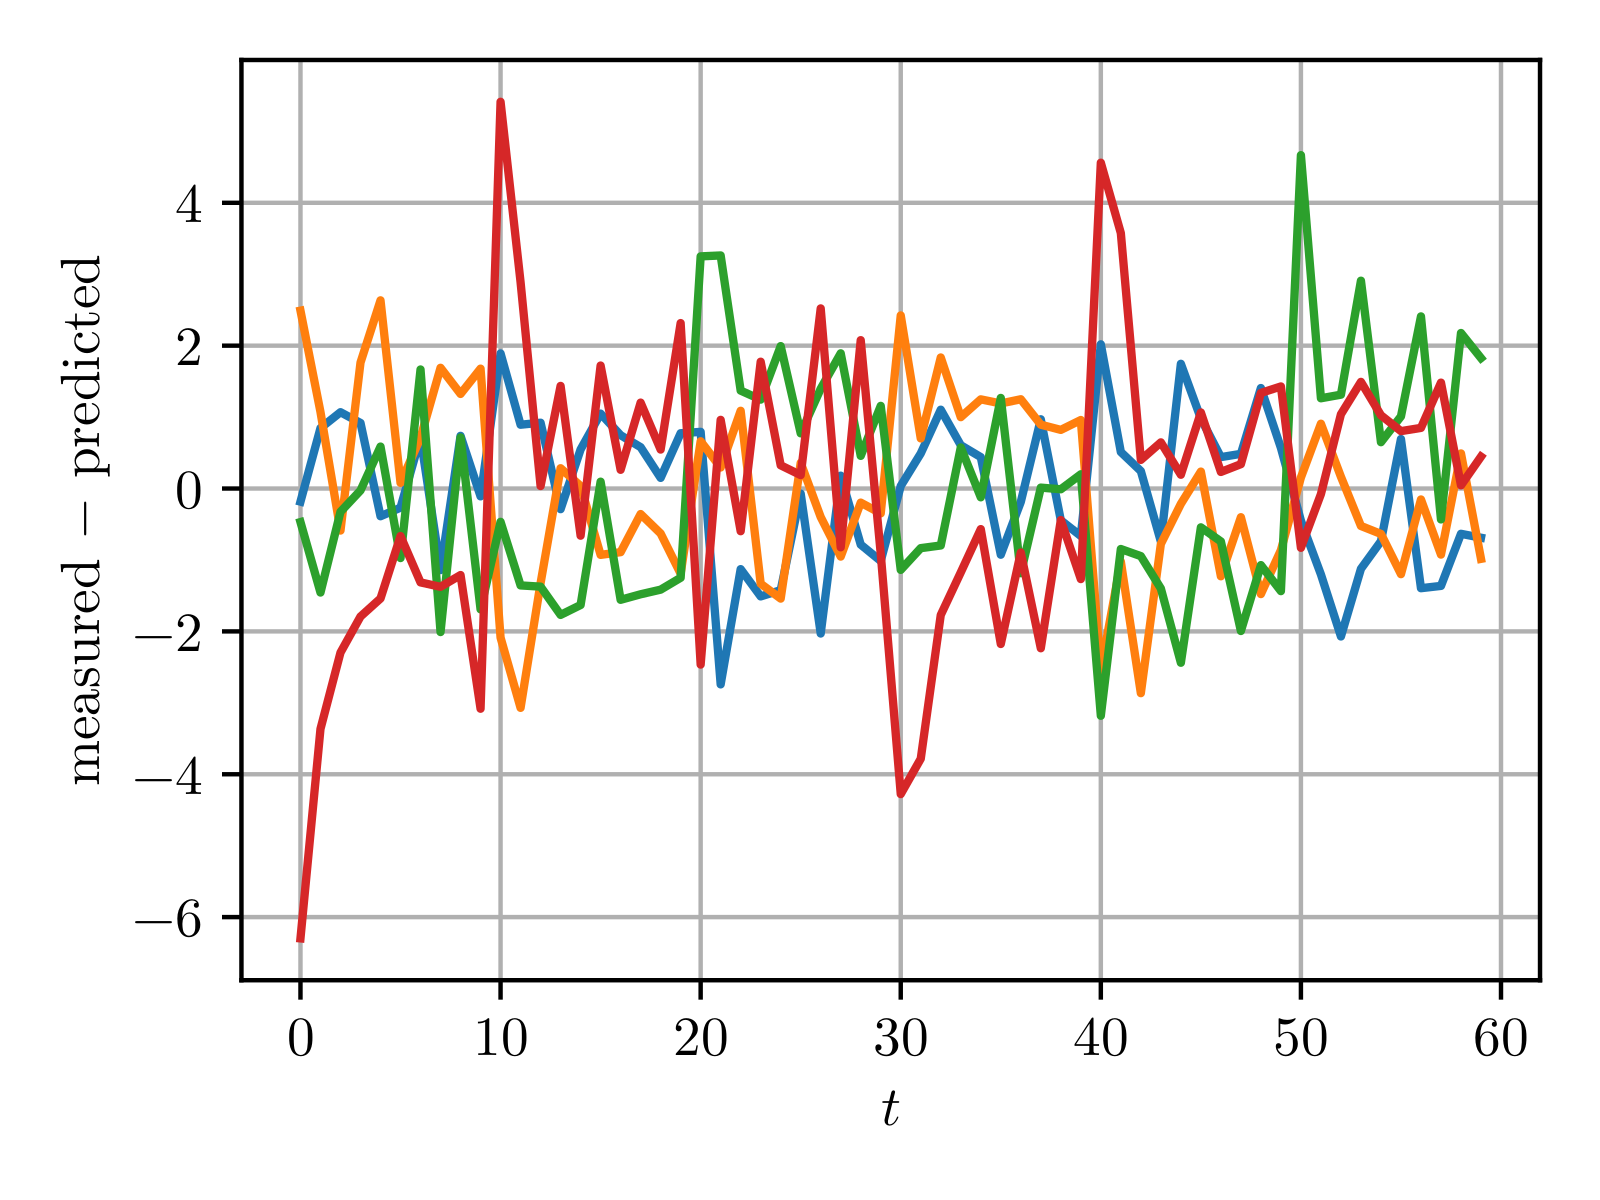

In [16]:
ftl.img_grid([
    plot(X[:, 0, 90:150], X_pred[:, 0, 90:150], 'res_x'),
    plot(X[:, 1, 90:150], X_pred[:, 1, 90:150], 'res_y'),
], n_columns=2)